##  <span style='background :#96e773' > 1. Introduction </span>

Ce notebook est dédié à l'analyse exploratoire des jeux de données "application_train.csv" et "application_test.csv" issus de la compétition Kaggle "Home Credit Default Risk".

In [1]:
# Importation des librairies

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import sys
import sklearn

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Versions
print('Version des librairies utilisées:')
print('Python ' + sys.version)
print('Pandas ' + pd.__version__)
print('NumPy ' + np.__version__)
print('Seaborn ' + sns.__version__)
print('Matplotlib ' + matplotlib.__version__)
print('Sklearn ' + sklearn.__version__)

Version des librairies utilisées:
Python 3.10.6 (tags/v3.10.6:9c7b4bd, Aug  1 2022, 21:53:49) [MSC v.1932 64 bit (AMD64)]
Pandas 1.5.2
NumPy 1.23.5
Seaborn 0.12.2
Matplotlib 3.5.3
Sklearn 1.2.2


In [2]:
from matplotlib import rcParams

# Définition des tailles de polices des figures


SMALL_SIZE = 15
MEDIUM_SIZE = 16
BIGGER_SIZE = 17

plt.rc('font', size=SMALL_SIZE)  # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)  # legend fontsize
plt.rc('axes', titlesize=BIGGER_SIZE)

rcParams['axes.titlepad'] = 20
plt.rcParams['figure.dpi'] = 100

sns.set(style="darkgrid")

**Fonctions**

In [3]:
def dim(df):
    x, y = df.shape
    print(f'Le jeu de données contient {x} lignes et {y} colonnes.')

In [4]:
def missing_values(df):
    a = df.isna().sum().sum()
    b = round(df.isna().mean().mean() * 100)
    print(f'Le jeu de données contient {a} valeurs manquantes ({b}%).')

In [5]:
def recap_missing_values(df):
    df = pd.DataFrame(df)
    a = df.notna().sum()
    b = df.isna().sum()
    c = round((1 - df.isna().mean()) * 100, 2)
    d = pd.concat([a, b, c], axis=1).reset_index()
    d.columns = ['Variable',
                 'Nombre de valeurs renseignées',
                 'Nombre de valeurs manquantes',
                 'Taux de remplissage (%)']
    return d

In [6]:
# Distribution empirique

def distri(df, col, xlim=None, line=True, kde=True, log=False):
    sns.set(style="darkgrid")

    # creating a figure composed of two matplotlib.Axes objects (ax_box and ax_hist)
    # noinspection PyTypeChecker
    g, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(7, 5))

    # assigning a graph to each ax
    sns.boxplot(x=df[col], ax=ax_box)
    sns.histplot(x=df[col], ax=ax_hist, kde=kde)

    # Remove x-axis name for the boxplot
    ax_box.set(xlabel='')

    mean = round(df[col].mean(), 2)
    median = round(df[col].median(), 2)
    std = round(df[col].std(ddof=0), 2)
    c_var = round(std / mean, 2)
    skew = round(df[col].skew(), 2)
    kurtosis = round(df[col].kurtosis(), 2)

    mean_text = "mean = " + str(mean)
    median_text = "median = " + str(median)
    std_text = "std = " + str(std)
    c_var_text = "coeff var = " + str(c_var)
    skew_text = "skew = " + str(skew)
    kurtosis_text = "kurtosis = " + str(kurtosis)

    plt.text(0.75, 0.4,
             mean_text + "\n" + median_text + "\n" + std_text + "\n" + c_var_text + "\n" + skew_text + "\n" + kurtosis_text,
             fontsize=12, color='k',
             ha='left', va='bottom',
             transform=plt.gca().transAxes)

    if line:

        ax_hist.axvline(mean, color='red', linestyle='--', linewidth="2", label="mean")
        ax_hist.axvline(median, color='mediumblue', linestyle='-.', linewidth="2", label="median")
        plt.legend()
    else:
        pass

    if log:
        ax_hist.set_yscale('log')
    else:
        pass

    if xlim:
        plt.xlim(xlim)

    plt.show()

In [7]:
def pie(df, col, titre, explode=True):
    plt.title(titre)

    nbr = df[col].value_counts().sort_index()

    if explode:
        explode = [0.1]
        for i in range(len(nbr) - 1):
            explode.append(0)
    else:
        explode = [0]
        for i in range(len(nbr) - 1):
            explode.append(0)

    plt.pie(nbr, explode=explode, labels=nbr.index, autopct='%1.1f%%',
            textprops={'fontsize': 14, 'color': 'black', 'backgroundcolor': 'w'}, startangle=90)

    plt.axis('equal')
    plt.show()

In [8]:
def getDuplicateColumns(df):
    # Create an empty set
    duplicateColumnNames = set()

    # Iterate through all the columns
    # of dataframe
    for x in range(df.shape[1]):

        # Take column at xth index.
        col = df.iloc[:, x]

        # Iterate through all the columns in
        # DataFrame from (x + 1)th index to
        # last index
        for y in range(x + 1, df.shape[1]):

            # Take column at yth index.
            otherCol = df.iloc[:, y]

            # Check if two columns at x & y
            # index are equal or not,
            # if equal then adding
            # to the set
            if col.equals(otherCol):
                duplicateColumnNames.add(df.columns.values[y])

    # Return list of unique column names
    # whose contents are duplicates.
    return list(duplicateColumnNames)

In [9]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024 ** 2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float32)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024 ** 2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [10]:
def detect_outliers(df, var, n, method='all', quantile_low=0.05, quantile_high=0.95, std_dev=3, iqr_factor=1.5):
    """
    Detects outliers in a pandas DataFrame using one or more methods.

    Parameters:
    - df: pandas DataFrame to be checked for outliers
    - n: minimum number of methods that must tag a data point as an outlier for it to be considered an outlier (default: 2)
    - method: one of 'all', 'percentile', 'std_dev', or 'iqr'; the outlier detection method to be used (default: 'all')
    - percentile_low: lower percentile value used in percentile method (default: 5)
    - percentile_high: upper percentile value used in percentile method (default: 95)
    - std_dev: number of standard deviations used in standard deviation method (default: 3)
    - iqr: number of interquartile ranges used in interquartile range method (default: 1.5)

    Returns:
    - outlier_df: pandas DataFrame with an additional column 'outlier' containing a boolean value indicating whether each data point is an outlier or not
    """
    outlier_count = np.zeros(len(df))

    if method in ('all', 'percentile'):
        q1 = df[var].quantile(quantile_low)
        q3 = df[var].quantile(quantile_high)
        is_outlier_percentile = (df[var] < q1) | (df[var] > q3)
        outlier_count += is_outlier_percentile

    if method in ('all', 'std_dev'):
        std = np.std(df[var], axis=0)
        mean = np.mean(df[var], axis=0)
        is_outlier_std_dev = np.abs(df[var] - mean) > std_dev * std
        outlier_count += is_outlier_std_dev

    if method in ('all', 'iqr'):
        q1 = df[var].quantile(0.25)
        q3 = df[var].quantile(0.75)
        iqr = q3 - q1
        is_outlier_iqr = (df[var] < q1 - iqr * iqr_factor) | (df[var] > q3 + iqr * iqr_factor)
        outlier_count += is_outlier_iqr

    outlier_df = df.copy()
    outlier_df['outlier_count'] = outlier_count

    return outlier_df[outlier_df['outlier_count']>=n].sort_values(by=var, ascending=False)

In [11]:
def percentile_report(df, columns):
    quantiles = [0, 0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 1]
    results = []
    for col in columns:
        col_results = []
        for q in quantiles:
            value = df[col].quantile(q)
            col_results.append(value)
        results.append(col_results)
    results_df = pd.DataFrame(results, columns=[f'{q*100}%' for q in quantiles], index=columns)
    return results_df

In [12]:
def compare_target_categ(df, var, figsize, rotate=False, order=False):
    sns.set(style="darkgrid")
    plt.figure(figsize=figsize)

    if order:
        temp = df.groupby(var)['TARGET'].mean().reset_index().rename(
            columns={'TARGET': 'Failure to Repay (%)'}).sort_values(by='Failure to Repay (%)', ascending=False)

    else:
        temp = df.groupby(var)['TARGET'].mean().reset_index().rename(columns={'TARGET': 'Failure to Repay (%)'})

    sns.barplot(temp, x=var, y='Failure to Repay (%)')

    if rotate:
        plt.xticks(rotation=90)
    plt.show()

In [13]:
def compare_target(df, var, xlim=None, common_norm=True, log_scale=False):
    sns.kdeplot(data=df, x=var, hue="TARGET", common_norm=common_norm, log_scale=log_scale)

    if xlim:
        plt.xlim(xlim)

    mean_0 = df[df['TARGET'] == 0][var].mean()
    mean_1 = df[df['TARGET'] == 1][var].mean()

    plt.axvline(mean_0, color=sns.color_palette()[0], linestyle='dashed', label=f'TARGET=0 Mean: {mean_0:.2f}')
    plt.axvline(mean_1, color=sns.color_palette()[1], linestyle='dashed', label=f'TARGET=1 Mean: {mean_1:.2f}')

    # Add legend and show plot
    plt.legend()
    plt.show()

In [14]:
def compute_mode_percentage(df, columns, threshold, pr=True):
    data = []
    for col in columns:
        mode = df[col].mode().values[0]
        mode_perc = df[col].value_counts(normalize=True)[mode]

        data.append({'Column': col, 'Mode': mode, 'Mode_pct': mode_perc})

    result_df = pd.DataFrame(data)
    col = result_df.loc[result_df['Mode_pct'] >= threshold, 'Column'].tolist()

    if pr:
        print(result_df.sort_values(by='Mode_pct'))
        print('')

    print('Liste des features à supprimer :')
    print(col)
    return col

In [15]:
def iv_woe(data, target, bins=10):
    #Empty Dataframe
    newDF = pd.DataFrame()

    #Extract Column Names
    cols = data.columns

    #Run WOE and IV on all the independent variables
    for ivars in cols[~cols.isin([target])]:

        if (data[ivars].dtype.kind in 'bifc') and (len(np.unique(data[ivars])) > 10):
            binned_x = pd.qcut(data[ivars], bins, duplicates='drop')
            d0 = pd.DataFrame({'x': binned_x, 'y': data[target]})

        else:
            d0 = pd.DataFrame({'x': data[ivars], 'y': data[target]})

        d0 = d0.astype({"x": str})
        d = d0.groupby("x", as_index=False, dropna=False).agg({"y": ["count", "sum"]})
        d.columns = ['Cutoff', 'N', 'Events']

        d['% of Events'] = np.maximum(d['Events'], 0.5) / d['Events'].sum()
        d['Non-Events'] = d['N'] - d['Events']
        d['% of Non-Events'] = np.maximum(d['Non-Events'], 0.5) / d['Non-Events'].sum()
        d['WoE'] = np.log(d['% of Non-Events'] / d['% of Events'])
        d['IV'] = d['WoE'] * (d['% of Non-Events'] - d['% of Events'])

        d.insert(loc=0, column='Variable', value=ivars)

        temp = pd.DataFrame({"Variable": [ivars], "IV": [d['IV'].sum()]}, columns=["Variable", "IV"])
        newDF = pd.concat([newDF, temp], axis=0)

    return newDF

<br>

---

##  <span style='background :#96e773' > 2. Chargements des jeux de données </span>

On charge les deux jeux de données.

In [16]:
import os

liste_fichier = os.listdir("./data/")
liste_fichier

['application_test.csv',
 'application_train.csv',
 'bureau.csv',
 'bureau_balance.csv',
 'credit_card_balance.csv',
 'HomeCredit_columns_description.csv',
 'installments_payments.csv',
 'POS_CASH_balance.csv',
 'previous_application.csv',
 'sample_submission.csv']

In [17]:
train = pd.read_csv("./data/application_train.csv")
test = pd.read_csv("./data/application_test.csv")

<br>

---

##  <span style='background :#96e773' > 3. application_train & application_test </span>
### <span style='background :#e3e33d' > 3.1 Description des données </span>

In [18]:
train = reduce_mem_usage(train)

Memory usage of dataframe is 286.23 MB
Memory usage after optimization is: 128.16 MB
Decreased by 55.2%


In [19]:
test = reduce_mem_usage(test)

Memory usage of dataframe is 45.00 MB
Memory usage after optimization is: 20.27 MB
Decreased by 55.0%


In [20]:
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
dim(train)
missing_values(train)

Le jeu de données contient 307511 lignes et 122 colonnes.
Le jeu de données contient 9152465 valeurs manquantes (24%).


In [22]:
dim(test)
missing_values(test)

Le jeu de données contient 48744 lignes et 121 colonnes.
Le jeu de données contient 1404419 valeurs manquantes (24%).


In [23]:
train.dtypes.value_counts()

float32    65
int8       37
object     16
int32       2
int16       2
dtype: int64

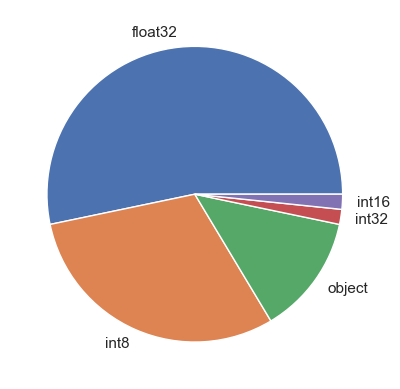

In [24]:
train.dtypes.value_counts().plot.pie()
plt.ylabel('')
plt.show()

In [25]:
list_col = train.columns.tolist()

In [26]:
list_var_categ = train.select_dtypes('object').columns.tolist()
list_var_categ

['NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'OCCUPATION_TYPE',
 'WEEKDAY_APPR_PROCESS_START',
 'ORGANIZATION_TYPE',
 'FONDKAPREMONT_MODE',
 'HOUSETYPE_MODE',
 'WALLSMATERIAL_MODE',
 'EMERGENCYSTATE_MODE']

In [27]:
M_train = recap_missing_values(train)
M_train

,Variable,Nombre de valeurs renseignées,Nombre de valeurs manquantes,Taux de remplissage (%)
0,SK_ID_CURR,307511,0,100.0
1,TARGET,307511,0,100.0
2,NAME_CONTRACT_TYPE,307511,0,100.0
3,CODE_GENDER,307511,0,100.0
4,FLAG_OWN_CAR,307511,0,100.0
...,...,...,...,...
117,AMT_REQ_CREDIT_BUREAU_DAY,265992,41519,86.5
118,AMT_REQ_CREDIT_BUREAU_WEEK,265992,41519,86.5
119,AMT_REQ_CREDIT_BUREAU_MON,265992,41519,86.5
120,AMT_REQ_CREDIT_BUREAU_QRT,265992,41519,86.5


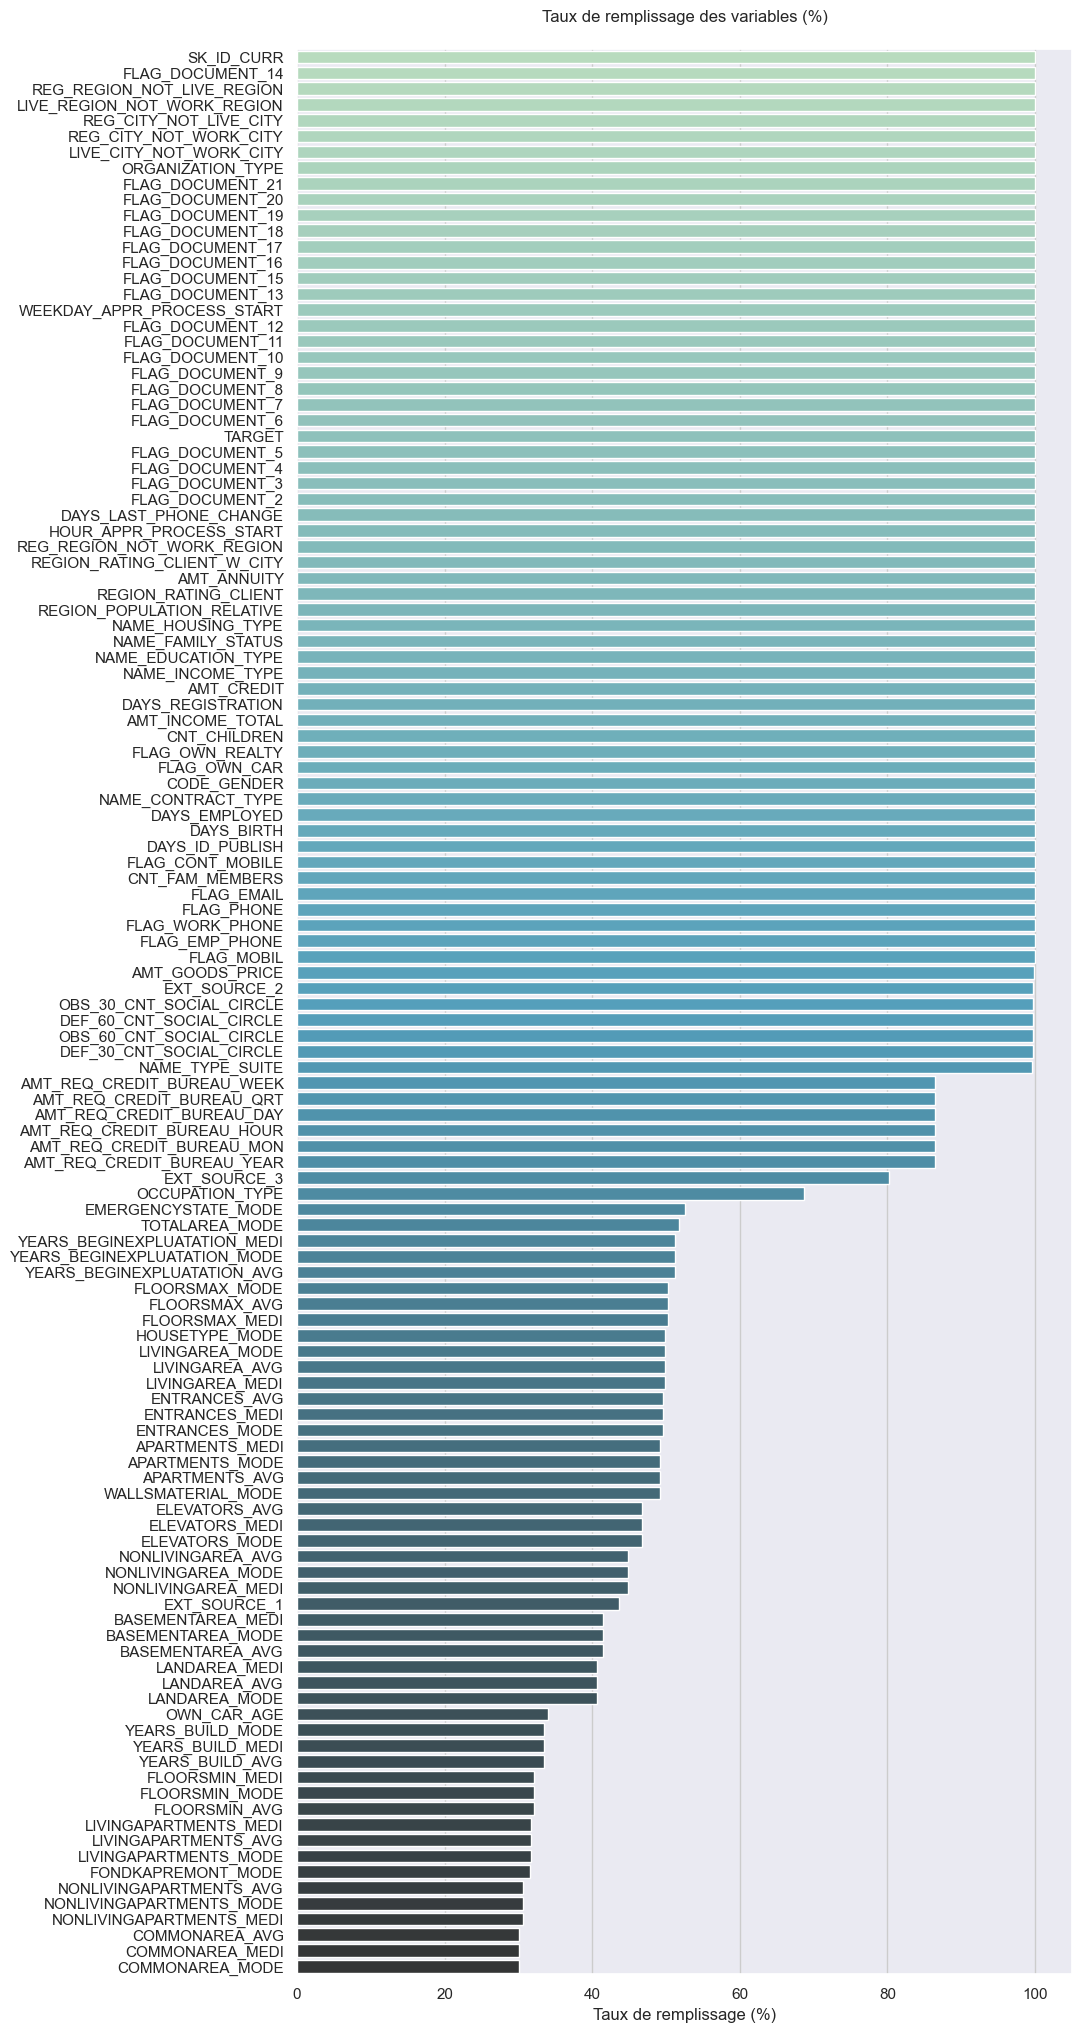

In [28]:
# Taux de remplissage par colonne

plt.figure(figsize=(10, 25))

ax = sns.barplot(data=M_train.sort_values(by="Taux de remplissage (%)", ascending=False), y="Variable",
                 x="Taux de remplissage (%)", palette="GnBu_d")

plt.xlabel("Taux de remplissage (%)")
ax.set(ylabel=None)
plt.grid(axis='x', color='0.8')
plt.title("Taux de remplissage des variables (%)")

plt.show()

On remarque que toutes les variables portant les suffixes "_MODE", "_AVG" et "_MEDI" ont un taux de remplissage (TDR) < 60 %.

In [29]:
cols_buildings = [i for i in train.columns if ('_MODE' in i) | ('_AVG' in i) | ('_MEDI' in i)]
print(f'Nombre de variables liées au batiment du client: {len(cols_buildings)}')
cols_buildings

Nombre de variables liées au batiment du client: 47


['APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_AVG',
 'YEARS_BUILD_AVG',
 'COMMONAREA_AVG',
 'ELEVATORS_AVG',
 'ENTRANCES_AVG',
 'FLOORSMAX_AVG',
 'FLOORSMIN_AVG',
 'LANDAREA_AVG',
 'LIVINGAPARTMENTS_AVG',
 'LIVINGAREA_AVG',
 'NONLIVINGAPARTMENTS_AVG',
 'NONLIVINGAREA_AVG',
 'APARTMENTS_MODE',
 'BASEMENTAREA_MODE',
 'YEARS_BEGINEXPLUATATION_MODE',
 'YEARS_BUILD_MODE',
 'COMMONAREA_MODE',
 'ELEVATORS_MODE',
 'ENTRANCES_MODE',
 'FLOORSMAX_MODE',
 'FLOORSMIN_MODE',
 'LANDAREA_MODE',
 'LIVINGAPARTMENTS_MODE',
 'LIVINGAREA_MODE',
 'NONLIVINGAPARTMENTS_MODE',
 'NONLIVINGAREA_MODE',
 'APARTMENTS_MEDI',
 'BASEMENTAREA_MEDI',
 'YEARS_BEGINEXPLUATATION_MEDI',
 'YEARS_BUILD_MEDI',
 'COMMONAREA_MEDI',
 'ELEVATORS_MEDI',
 'ENTRANCES_MEDI',
 'FLOORSMAX_MEDI',
 'FLOORSMIN_MEDI',
 'LANDAREA_MEDI',
 'LIVINGAPARTMENTS_MEDI',
 'LIVINGAREA_MEDI',
 'NONLIVINGAPARTMENTS_MEDI',
 'NONLIVINGAREA_MEDI',
 'FONDKAPREMONT_MODE',
 'HOUSETYPE_MODE',
 'TOTALAREA_MODE',
 'WALLSMATERIAL_MODE',
 'EMER

Ces variables sont liées au batiment de résidence du client et ont pour description unique :
"Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor".

In [30]:
print(recap_missing_values(train[cols_buildings])['Taux de remplissage (%)'].min())
print(recap_missing_values(train[cols_buildings])['Taux de remplissage (%)'].max())

30.13
52.6


Les TDR de ces variables sont compris entre 30 et 53 %. Nous allons supprimer ces variables car une imputation serait trop hasardeuse.

In [31]:
train.drop(columns=cols_buildings, inplace=True)
test.drop(columns=cols_buildings, inplace=True)

In [32]:
list_col = train.columns.tolist()
list_var_categ = train.select_dtypes('object').columns.tolist()

In [33]:
M_train = recap_missing_values(train)
M_train[M_train["Taux de remplissage (%)"] < 90]

,Variable,Nombre de valeurs renseignées,Nombre de valeurs manquantes,Taux de remplissage (%)
21,OWN_CAR_AGE,104582,202929,34.01
28,OCCUPATION_TYPE,211120,96391,68.65
41,EXT_SOURCE_1,134133,173378,43.62
43,EXT_SOURCE_3,246546,60965,80.17
69,AMT_REQ_CREDIT_BUREAU_HOUR,265992,41519,86.50
70,AMT_REQ_CREDIT_BUREAU_DAY,265992,41519,86.50
71,AMT_REQ_CREDIT_BUREAU_WEEK,265992,41519,86.50
72,AMT_REQ_CREDIT_BUREAU_MON,265992,41519,86.50
73,AMT_REQ_CREDIT_BUREAU_QRT,265992,41519,86.50
74,AMT_REQ_CREDIT_BUREAU_YEAR,265992,41519,86.50


Parmi les variables non liées au batiment de résidence, on dénombre 2 variables avec un TDR < 50 % ("OWN_CAR_AGE", "EXT_SOURCE_1") et une variable avec un TDR d'environ 70 % ("OCCUPATION_TYPE").

Nous verrons par la suite quelle stratégie adopter avec ces variables.

In [34]:
# Recherche de colonnes doublons

duplicateColNames = getDuplicateColumns(train)
d = len(duplicateColNames)
print(f'Nombre de colonnes doublons : {d}')

Nombre de colonnes doublons : 0


In [35]:
# Recherche de lignes doublons sur chaque variable

d = train.duplicated(keep='first').sum()
print(f'Nombre de lignes doublons : {d}')

Nombre de lignes doublons : 0


In [36]:
# Recherche de lignes doublons sur chaque variable

d = test.duplicated(keep='first').sum()
print(f'Nombre de lignes doublons : {d}')

Nombre de lignes doublons : 0


In [37]:
M_test = recap_missing_values(test)
M_test

,Variable,Nombre de valeurs renseignées,Nombre de valeurs manquantes,Taux de remplissage (%)
0,SK_ID_CURR,48744,0,100.00
1,NAME_CONTRACT_TYPE,48744,0,100.00
2,CODE_GENDER,48744,0,100.00
3,FLAG_OWN_CAR,48744,0,100.00
4,FLAG_OWN_REALTY,48744,0,100.00
...,...,...,...,...
69,AMT_REQ_CREDIT_BUREAU_DAY,42695,6049,87.59
70,AMT_REQ_CREDIT_BUREAU_WEEK,42695,6049,87.59
71,AMT_REQ_CREDIT_BUREAU_MON,42695,6049,87.59
72,AMT_REQ_CREDIT_BUREAU_QRT,42695,6049,87.59


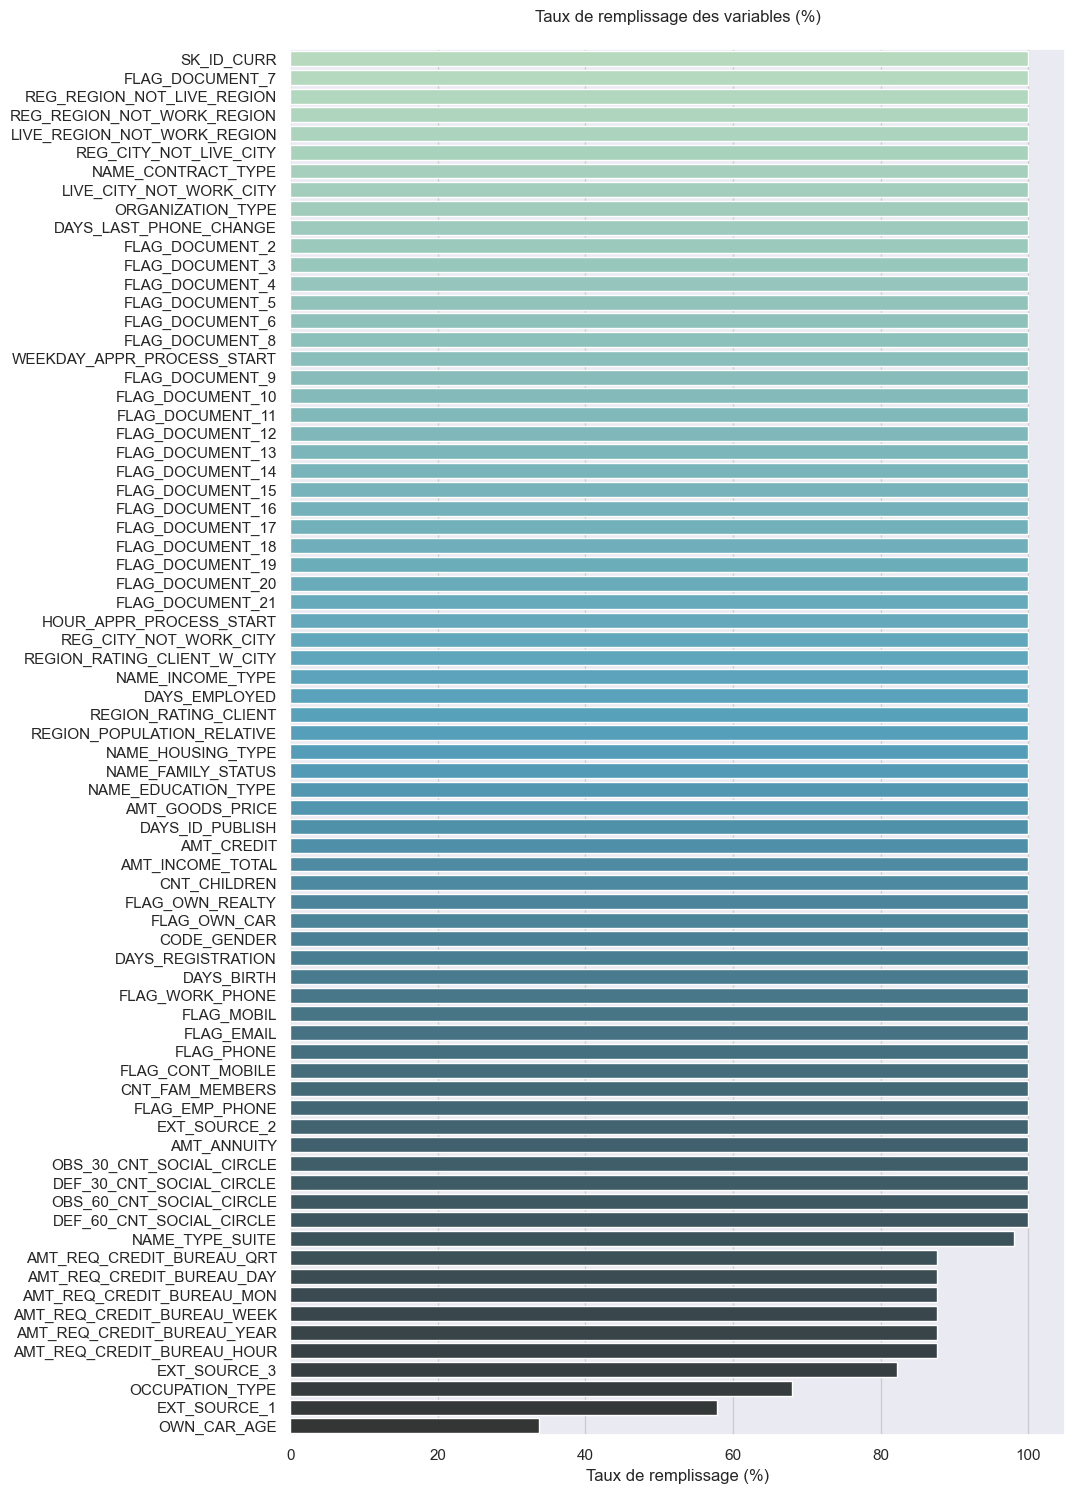

In [38]:
# Taux de remplissage par colonne

plt.figure(figsize=(10, 18))

ax = sns.barplot(data=M_test.sort_values(by="Taux de remplissage (%)", ascending=False), y="Variable",
                 x="Taux de remplissage (%)", palette="GnBu_d")

plt.xlabel("Taux de remplissage (%)")
ax.set(ylabel=None)
plt.grid(axis='x', color='0.8')
plt.title("Taux de remplissage des variables (%)")

plt.show()

In [39]:
M_test = recap_missing_values(test)
M_test[M_test["Taux de remplissage (%)"] < 90]

,Variable,Nombre de valeurs renseignées,Nombre de valeurs manquantes,Taux de remplissage (%)
20,OWN_CAR_AGE,16432,32312,33.71
27,OCCUPATION_TYPE,33139,15605,67.99
40,EXT_SOURCE_1,28212,20532,57.88
42,EXT_SOURCE_3,40076,8668,82.22
68,AMT_REQ_CREDIT_BUREAU_HOUR,42695,6049,87.59
69,AMT_REQ_CREDIT_BUREAU_DAY,42695,6049,87.59
70,AMT_REQ_CREDIT_BUREAU_WEEK,42695,6049,87.59
71,AMT_REQ_CREDIT_BUREAU_MON,42695,6049,87.59
72,AMT_REQ_CREDIT_BUREAU_QRT,42695,6049,87.59
73,AMT_REQ_CREDIT_BUREAU_YEAR,42695,6049,87.59


La distribution des valeurs manquantes est similaire dans les datasets train et test.

<br>

---

**Nous allons concentrer notre analyse sur le jeu d'entrainement afin d'éviter toute fuite de données venant du jeu de test. Nous utiliserons le jeu de test uniquement pour comparer les modalités des variables catégorielles.**

### <span style='background :#e3e33d' > 3.2 Clé primaire et target </span>
#### <span style='background :#cdcdfc' > SK_ID_CURR </span>

La variable "SK_ID_CURR" est la clé primaire qui identifie chaque prêt.

In [40]:
train["SK_ID_CURR"].duplicated(keep='first').sum()

0

Aucun doublon.

#### <span style='background :#cdcdfc' > TARGET </span>

La variable "TARGET" est une variable binaire indiquant si le prêt a été remboursé (0) ou non (1).

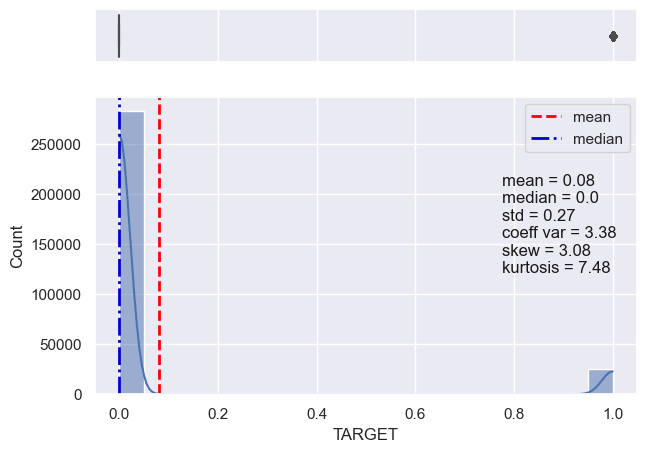

In [41]:
distri(train, "TARGET")

In [42]:
train['TARGET'].value_counts(normalize=True)

0    0.919271
1    0.080729
Name: TARGET, dtype: float64

Les deux classes sont fortement déséquilibrées.

<br>

---

### <span style='background :#e3e33d' > 3.3 Nettoyage des variables </span>

Le reste des variables contiennent des informations diverses sur le bénéficiaire du prêt (situation familiale, lieu de résidence, emploi, revenus, etc) et sur le crédit (type, montant, etc). Nous allons nous focaliser sur les plus importantes.

In [43]:
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


#### <span style='background :#cdcdfc' > Variables catégorielles </span>

On commence par vérifier les variables catégorielles.

In [44]:
recap_missing_values(train[list_var_categ])

,Variable,Nombre de valeurs renseignées,Nombre de valeurs manquantes,Taux de remplissage (%)
0,NAME_CONTRACT_TYPE,307511,0,100.00
1,CODE_GENDER,307511,0,100.00
2,FLAG_OWN_CAR,307511,0,100.00
3,FLAG_OWN_REALTY,307511,0,100.00
4,NAME_TYPE_SUITE,306219,1292,99.58
5,NAME_INCOME_TYPE,307511,0,100.00
6,NAME_EDUCATION_TYPE,307511,0,100.00
7,NAME_FAMILY_STATUS,307511,0,100.00
8,NAME_HOUSING_TYPE,307511,0,100.00
9,OCCUPATION_TYPE,211120,96391,68.65


Parmi les variables catégorielles, la variable "OCCUPATION_TYPE" a le TDR le plus bas 69 %.

In [45]:
# Number of unique classes in each object column
train[list_var_categ].nunique()

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
dtype: int64

In [46]:
for f in list_var_categ:
    if train[f].nunique() < 10:
        print(f'{f} : {train[f].unique()}')
        print('')

NAME_CONTRACT_TYPE : ['Cash loans' 'Revolving loans']

CODE_GENDER : ['M' 'F' 'XNA']

FLAG_OWN_CAR : ['N' 'Y']

FLAG_OWN_REALTY : ['Y' 'N']

NAME_TYPE_SUITE : ['Unaccompanied' 'Family' 'Spouse, partner' 'Children' 'Other_A' nan
 'Other_B' 'Group of people']

NAME_INCOME_TYPE : ['Working' 'State servant' 'Commercial associate' 'Pensioner' 'Unemployed'
 'Student' 'Businessman' 'Maternity leave']

NAME_EDUCATION_TYPE : ['Secondary / secondary special' 'Higher education' 'Incomplete higher'
 'Lower secondary' 'Academic degree']

NAME_FAMILY_STATUS : ['Single / not married' 'Married' 'Civil marriage' 'Widow' 'Separated'
 'Unknown']

NAME_HOUSING_TYPE : ['House / apartment' 'Rented apartment' 'With parents'
 'Municipal apartment' 'Office apartment' 'Co-op apartment']

WEEKDAY_APPR_PROCESS_START : ['WEDNESDAY' 'MONDAY' 'THURSDAY' 'SUNDAY' 'SATURDAY' 'FRIDAY' 'TUESDAY']



In [47]:
for f in list_var_categ:
    if train[f].nunique() > 10:
        print(f'{f} : {train[f].unique()}')
        print('')

OCCUPATION_TYPE : ['Laborers' 'Core staff' 'Accountants' 'Managers' nan 'Drivers'
 'Sales staff' 'Cleaning staff' 'Cooking staff' 'Private service staff'
 'Medicine staff' 'Security staff' 'High skill tech staff'
 'Waiters/barmen staff' 'Low-skill Laborers' 'Realty agents' 'Secretaries'
 'IT staff' 'HR staff']

ORGANIZATION_TYPE : ['Business Entity Type 3' 'School' 'Government' 'Religion' 'Other' 'XNA'
 'Electricity' 'Medicine' 'Business Entity Type 2' 'Self-employed'
 'Transport: type 2' 'Construction' 'Housing' 'Kindergarten'
 'Trade: type 7' 'Industry: type 11' 'Military' 'Services'
 'Security Ministries' 'Transport: type 4' 'Industry: type 1' 'Emergency'
 'Security' 'Trade: type 2' 'University' 'Transport: type 3' 'Police'
 'Business Entity Type 1' 'Postal' 'Industry: type 4' 'Agriculture'
 'Restaurant' 'Culture' 'Hotel' 'Industry: type 7' 'Trade: type 3'
 'Industry: type 3' 'Bank' 'Industry: type 9' 'Insurance' 'Trade: type 6'
 'Industry: type 2' 'Transport: type 1' 'Industry: typ

On note la présence de modalités signifiant l'absence de données : "XNA", "nan", "Unknown".

On vérifie que les jeux d'entrainement et de test ont les mêmes modalités.

In [48]:
for c in list_var_categ:
    c_train = set(train[c].unique())
    c_test = set(test[c].unique())
    diff_train = c_test - c_train
    diff_test = c_train - c_test
    if len(diff_train) > 0:
        print('Category(ies) missing in train set for feature ' + c + ':', diff_train)
    if len(diff_test) > 0:
        print('Category(ies) missing in test set for feature ' + c + ':', diff_test)

Category(ies) missing in test set for feature CODE_GENDER: {'XNA'}
Category(ies) missing in test set for feature NAME_INCOME_TYPE: {'Maternity leave'}
Category(ies) missing in test set for feature NAME_FAMILY_STATUS: {'Unknown'}


Les modalités "XNA", "Maternity leave" et "Unknown" sont absentes du jeu de test.

In [49]:
print(train.loc[train['CODE_GENDER'] == 'XNA'].shape[0])

4


On remplace les 4 modalités "XNA" de la catégorie "CODE_GENDER" par "F".

In [50]:
train.loc[train['CODE_GENDER'] == 'XNA', 'CODE_GENDER'] = 'F'

In [51]:
print(train.loc[train['NAME_INCOME_TYPE'] == 'Maternity leave'].shape[0])

5


On supprime les 5 prêts où la modalité "Maternity leave" de la catégorie "NAME_INCOME_TYPE" apparait.

In [52]:
train = train[train['NAME_INCOME_TYPE'] != 'Maternity leave']

In [53]:
print(train.loc[train['NAME_FAMILY_STATUS'] == 'Unknown'].shape[0])

2


On supprime les 2 prêts où la modalité "Unknown" de la catégorie "NAME_FAMILY_STATUS" apparait.

In [54]:
train = train[train['NAME_FAMILY_STATUS'] != 'Unknown']

Regardons de plus près les valeurs manquantes de la catégorie "OCCUPATION_TYPE".

In [55]:
train.loc[train['OCCUPATION_TYPE'].isna()]['NAME_INCOME_TYPE'].value_counts()

Pensioner               55357
Working                 24920
Commercial associate    12297
State servant            3787
Unemployed                 22
Student                     5
Businessman                 2
Name: NAME_INCOME_TYPE, dtype: int64

Les sources de revenus de type "Pensioner" et "Unemployed" peuvent servir à renseigner l'occupation du client.

In [56]:
train.loc[train['NAME_INCOME_TYPE'] == 'Pensioner', 'OCCUPATION_TYPE'] = 'Pensioner'
train.loc[train['NAME_INCOME_TYPE'] == 'Unemployed', 'OCCUPATION_TYPE'] = 'Unemployed'

Regardons de plus près les valeurs manquantes de la catégorie "ORGANIZATION_TYPE".

In [57]:
train.loc[train['ORGANIZATION_TYPE'] == 'XNA']['NAME_INCOME_TYPE'].value_counts()

Pensioner     55352
Unemployed       22
Name: NAME_INCOME_TYPE, dtype: int64

Les clients dont le secteur d'activité est non renseigné sont tous retraités ou sans emploi. On utilise les sources de revenus pour remplacer ces valeurs manquantes.

In [58]:
train.loc[train['NAME_INCOME_TYPE'] == 'Pensioner', 'ORGANIZATION_TYPE'] = 'Pensioner'
train.loc[train['NAME_INCOME_TYPE'] == 'Unemployed', 'ORGANIZATION_TYPE'] = 'Unemployed'

On remplace les valeurs manquantes restantes par la mention "Unknown".

In [59]:
train[list_var_categ] = train[list_var_categ].fillna('Unknown')

In [60]:
missing_values(train[list_var_categ])

Le jeu de données contient 0 valeurs manquantes (0%).


On vérifie les modalités des variables catégorielles après les traitements.

In [61]:
for f in list_var_categ:
    if train[f].nunique() < 10:
        print(f'{f} : {train[f].unique()}')
        print('')

NAME_CONTRACT_TYPE : ['Cash loans' 'Revolving loans']

CODE_GENDER : ['M' 'F']

FLAG_OWN_CAR : ['N' 'Y']

FLAG_OWN_REALTY : ['Y' 'N']

NAME_TYPE_SUITE : ['Unaccompanied' 'Family' 'Spouse, partner' 'Children' 'Other_A' 'Unknown'
 'Other_B' 'Group of people']

NAME_INCOME_TYPE : ['Working' 'State servant' 'Commercial associate' 'Pensioner' 'Unemployed'
 'Student' 'Businessman']

NAME_EDUCATION_TYPE : ['Secondary / secondary special' 'Higher education' 'Incomplete higher'
 'Lower secondary' 'Academic degree']

NAME_FAMILY_STATUS : ['Single / not married' 'Married' 'Civil marriage' 'Widow' 'Separated']

NAME_HOUSING_TYPE : ['House / apartment' 'Rented apartment' 'With parents'
 'Municipal apartment' 'Office apartment' 'Co-op apartment']

WEEKDAY_APPR_PROCESS_START : ['WEDNESDAY' 'MONDAY' 'THURSDAY' 'SUNDAY' 'SATURDAY' 'FRIDAY' 'TUESDAY']



In [62]:
for f in list_var_categ:
    if train[f].nunique() > 10:
        print(f'{f} : {train[f].unique()}')
        print('')

OCCUPATION_TYPE : ['Laborers' 'Core staff' 'Accountants' 'Managers' 'Pensioner' 'Drivers'
 'Sales staff' 'Cleaning staff' 'Cooking staff' 'Unknown'
 'Private service staff' 'Medicine staff' 'Security staff'
 'High skill tech staff' 'Waiters/barmen staff' 'Low-skill Laborers'
 'Realty agents' 'Secretaries' 'IT staff' 'HR staff' 'Unemployed']

ORGANIZATION_TYPE : ['Business Entity Type 3' 'School' 'Government' 'Religion' 'Other'
 'Pensioner' 'Electricity' 'Medicine' 'Business Entity Type 2'
 'Self-employed' 'Transport: type 2' 'Construction' 'Housing'
 'Kindergarten' 'Trade: type 7' 'Industry: type 11' 'Military' 'Services'
 'Security Ministries' 'Transport: type 4' 'Industry: type 1' 'Emergency'
 'Security' 'Trade: type 2' 'University' 'Transport: type 3' 'Police'
 'Business Entity Type 1' 'Postal' 'Industry: type 4' 'Agriculture'
 'Restaurant' 'Culture' 'Hotel' 'Industry: type 7' 'Trade: type 3'
 'Industry: type 3' 'Bank' 'Industry: type 9' 'Insurance' 'Trade: type 6'
 'Industry: type 

Pour finir, on calcule le pourcentage occupé par le mode de chaque variable catégorielle et on liste les variables dont le mode occupe plus de 94 % des prêts.

In [63]:
col_to_del = compute_mode_percentage(train, list_var_categ, threshold=0.94)

                        Column                           Mode  Mode_pct
10  WEEKDAY_APPR_PROCESS_START                        TUESDAY  0.175279
9              OCCUPATION_TYPE                      Pensioner  0.180037
11           ORGANIZATION_TYPE         Business Entity Type 3  0.221100
5             NAME_INCOME_TYPE                        Working  0.516331
7           NAME_FAMILY_STATUS                        Married  0.638779
1                  CODE_GENDER                              F  0.658356
2                 FLAG_OWN_CAR                              N  0.659887
3              FLAG_OWN_REALTY                              Y  0.693669
6          NAME_EDUCATION_TYPE  Secondary / secondary special  0.710199
4              NAME_TYPE_SUITE                  Unaccompanied  0.808194
8            NAME_HOUSING_TYPE              House / apartment  0.887345
0           NAME_CONTRACT_TYPE                     Cash loans  0.904801

Liste des features à supprimer :
[]


#### <span style='background :#cdcdfc' > Variables binaires </span>

On s'intéresse maintenant aux variables binaires.

In [64]:
list_var_binaire = sorted(list(set(train.columns[train[list_col].nunique() == 2].tolist()) - set(list_var_categ)))
list_var_binaire.remove('TARGET')
list_var_binaire

['FLAG_CONT_MOBILE',
 'FLAG_DOCUMENT_10',
 'FLAG_DOCUMENT_11',
 'FLAG_DOCUMENT_12',
 'FLAG_DOCUMENT_13',
 'FLAG_DOCUMENT_14',
 'FLAG_DOCUMENT_15',
 'FLAG_DOCUMENT_16',
 'FLAG_DOCUMENT_17',
 'FLAG_DOCUMENT_18',
 'FLAG_DOCUMENT_19',
 'FLAG_DOCUMENT_2',
 'FLAG_DOCUMENT_20',
 'FLAG_DOCUMENT_21',
 'FLAG_DOCUMENT_3',
 'FLAG_DOCUMENT_4',
 'FLAG_DOCUMENT_5',
 'FLAG_DOCUMENT_6',
 'FLAG_DOCUMENT_7',
 'FLAG_DOCUMENT_8',
 'FLAG_DOCUMENT_9',
 'FLAG_EMAIL',
 'FLAG_EMP_PHONE',
 'FLAG_MOBIL',
 'FLAG_PHONE',
 'FLAG_WORK_PHONE',
 'LIVE_CITY_NOT_WORK_CITY',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION']

On liste les variables binaires dont le mode occupe plus de 94 % des prêts.

In [65]:
col_to_del = compute_mode_percentage(train, list_var_binaire, threshold=0.94)

                         Column  Mode  Mode_pct
14              FLAG_DOCUMENT_3     1  0.710040
24                   FLAG_PHONE     0  0.718937
29       REG_CITY_NOT_WORK_CITY     0  0.769548
25              FLAG_WORK_PHONE     0  0.800630
22               FLAG_EMP_PHONE     1  0.819885
26      LIVE_CITY_NOT_WORK_CITY     0  0.820448
17              FLAG_DOCUMENT_6     0  0.911943
19              FLAG_DOCUMENT_8     0  0.918622
28       REG_CITY_NOT_LIVE_CITY     0  0.921825
21                   FLAG_EMAIL     0  0.943279
31   REG_REGION_NOT_WORK_REGION     0  0.949236
27  LIVE_REGION_NOT_WORK_REGION     0  0.959347
30   REG_REGION_NOT_LIVE_REGION     0  0.984855
16              FLAG_DOCUMENT_5     0  0.984888
7              FLAG_DOCUMENT_16     0  0.990072
9              FLAG_DOCUMENT_18     0  0.991870
2              FLAG_DOCUMENT_11     0  0.996088
20              FLAG_DOCUMENT_9     0  0.996104
4              FLAG_DOCUMENT_13     0  0.996475
5              FLAG_DOCUMENT_14     0  0

Avant de supprimer ces variables, on crée la variable "CNT_DOC" qui compte le nombre de documents renseignés.

In [66]:
col_flag_doc = [f for f in train.columns if f.startswith('FLAG_DOC')]

train['CNT_DOC'] = train[col_flag_doc].sum(axis=1)

In [67]:
train.drop(columns=col_to_del, inplace=True)

In [68]:
list_col = train.columns.tolist()

In [69]:
list_var_binaire = sorted(list(set(train.columns[train[list_col].nunique() == 2].tolist()) - set(list_var_categ)))
list_var_binaire.remove('TARGET')
list_var_binaire

['FLAG_DOCUMENT_3',
 'FLAG_DOCUMENT_6',
 'FLAG_DOCUMENT_8',
 'FLAG_EMP_PHONE',
 'FLAG_PHONE',
 'FLAG_WORK_PHONE',
 'LIVE_CITY_NOT_WORK_CITY',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY']

#### <span style='background :#cdcdfc' > Variables liées aux revenus et au crédit </span>

In [70]:
col_revenu = ["AMT_INCOME_TOTAL",
              "AMT_CREDIT",
              "AMT_ANNUITY",
              "AMT_GOODS_PRICE"]

In [71]:
percentile_report(train, col_revenu)

,0%,1.0%,5.0%,10.0%,25.0%,50.0%,75.0%,90.0%,95.0%,99.0%,100%
AMT_INCOME_TOTAL,25650.0,45000.000000,67500.0,81000.0,112500.0,147150.0,202500.0,270000.0,337500.0,472500.0,117000000.0
AMT_CREDIT,45000.0,76410.000000,135000.0,180000.0,270000.0,513531.0,808650.0,1133748.0,1350000.0,1854000.0,4050000.0
AMT_ANNUITY,1615.5,6182.595215,9000.0,11074.5,16524.0,24903.0,34596.0,45954.0,53325.0,70006.5,258025.5
AMT_GOODS_PRICE,40500.0,67500.000000,135000.0,180000.0,238500.0,450000.0,679500.0,1093500.0,1305000.0,1800000.0,4050000.0


On remarque la présence de valeurs aberrantes en comparant les 99e centiles aux valeurs maximums.
Avant d'étudier ces valeurs aberrantes, on crée les variables suivantes :

In [72]:
train['PERC_INC_CRED'] = train['AMT_INCOME_TOTAL'] / train['AMT_CREDIT']
train['PERC_INC_ANN'] = train['AMT_INCOME_TOTAL'] / train['AMT_ANNUITY']

In [73]:
percentile_report(train, ["PERC_INC_CRED", "PERC_INC_ANN"])

,0%,1.0%,5.0%,10.0%,25.0%,50.0%,75.0%,90.0%,95.0%,99.0%,100%
PERC_INC_CRED,0.011801,0.076767,0.109222,0.133556,0.193803,0.306272,0.495376,0.750883,1.00000,1.679725,208.003326
PERC_INC_ANN,0.533059,2.068659,2.819549,3.315210,4.365541,6.141249,8.712181,12.500000,15.96594,25.333464,4466.586426


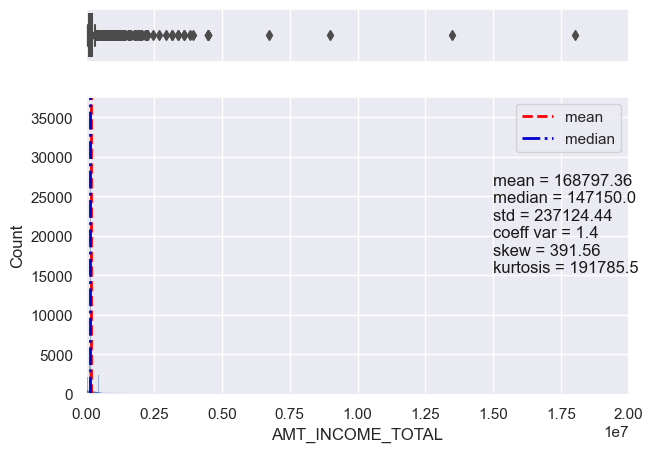

In [74]:
distri(train, "AMT_INCOME_TOTAL", xlim=[0, 2e7])

In [75]:
detect_outliers(train, "AMT_INCOME_TOTAL", n=1, method='iqr').head(5)[
    col_revenu + ['TARGET', 'PERC_INC_CRED', 'PERC_INC_ANN', 'NAME_INCOME_TYPE', 'OCCUPATION_TYPE',
                  'ORGANIZATION_TYPE']]

,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,TARGET,PERC_INC_CRED,PERC_INC_ANN,NAME_INCOME_TYPE,OCCUPATION_TYPE,ORGANIZATION_TYPE
12840,117000000.0,562491.0,26194.5,454500.0,1,208.003326,4466.586426,Working,Laborers,Business Entity Type 3
203693,18000090.0,675000.0,69295.5,675000.0,0,26.666800,259.758423,Commercial associate,Unknown,Business Entity Type 3
246858,13500000.0,1400503.5,130945.5,1368000.0,0,9.639390,103.096329,Commercial associate,Unknown,Business Entity Type 3
77768,9000000.0,1431531.0,132601.5,1377000.0,0,6.286975,67.872536,Working,Managers,Business Entity Type 1
131127,6750000.0,790830.0,52978.5,675000.0,0,8.535336,127.410179,Working,Laborers,Transport: type 4


Le client avec le plus haut revenu mensuel occupe un emploi de type "ouvrier". Il s'agit donc certainement d'une valeur aberrante et non atypique.

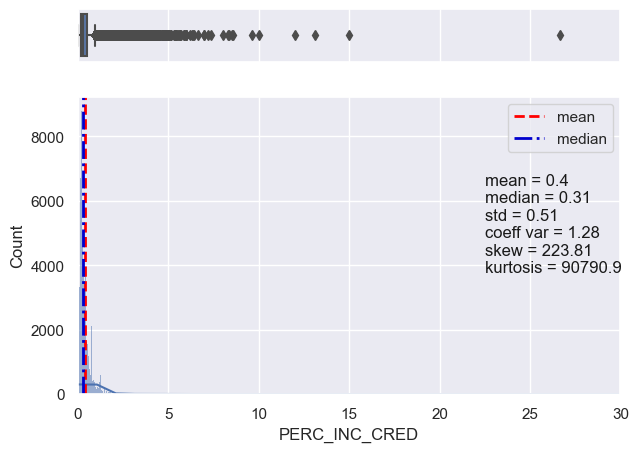

In [76]:
distri(train, 'PERC_INC_CRED', xlim=[0, 30])

In [77]:
detect_outliers(train, "PERC_INC_CRED", n=1, method='iqr').head(5)[
    col_revenu + ['TARGET', 'PERC_INC_CRED', 'PERC_INC_ANN', 'NAME_INCOME_TYPE', 'OCCUPATION_TYPE',
                  'ORGANIZATION_TYPE']]

,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,TARGET,PERC_INC_CRED,PERC_INC_ANN,NAME_INCOME_TYPE,OCCUPATION_TYPE,ORGANIZATION_TYPE
12840,117000000.0,562491.0,26194.5,454500.0,1,208.003326,4466.586426,Working,Laborers,Business Entity Type 3
203693,18000090.0,675000.0,69295.5,675000.0,0,26.666800,259.758423,Commercial associate,Unknown,Business Entity Type 3
258773,2700000.0,180000.0,9000.0,180000.0,0,15.000000,300.000000,Working,Managers,Police
146187,1890000.0,144000.0,11673.0,144000.0,0,13.125000,161.912109,State servant,Unknown,Emergency
78009,540000.0,45000.0,5598.0,45000.0,0,12.000000,96.463020,Commercial associate,Core staff,Bank


Le client avec le plus haut revenu mensuel gagne plus de 200 fois le montant de son crédit. Cela confirme le fait que ce revenu est une valeur aberrante.

In [78]:
train.nsmallest(10, 'PERC_INC_CRED')[col_revenu + ['TARGET', 'PERC_INC_CRED', 'PERC_INC_ANN', 'NAME_INCOME_TYPE', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE']]

,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,TARGET,PERC_INC_CRED,PERC_INC_ANN,NAME_INCOME_TYPE,OCCUPATION_TYPE,ORGANIZATION_TYPE
20727,25650.0,2173500.0,48118.5,2173500.0,1,0.011801,0.533059,Pensioner,Pensioner,Pensioner
35791,45000.0,2215224.0,58567.5,1980000.0,0,0.020314,0.768344,Pensioner,Pensioner,Pensioner
226137,45000.0,1800000.0,62698.5,1800000.0,1,0.025000,0.717721,Pensioner,Pensioner,Pensioner
255247,58500.0,2146500.0,51340.5,2146500.0,1,0.027254,1.139451,Working,Core staff,Police
158077,40500.0,1436850.0,42142.5,1125000.0,0,0.028187,0.961025,Pensioner,Pensioner,Pensioner
678,54000.0,1885500.0,74191.5,1885500.0,1,0.028640,0.727846,Pensioner,Pensioner,Pensioner
205575,36000.0,1223010.0,48627.0,1125000.0,1,0.029436,0.740329,Pensioner,Pensioner,Pensioner
103862,54000.0,1800000.0,47484.0,1800000.0,0,0.030000,1.137225,Pensioner,Pensioner,Pensioner
165555,27000.0,900000.0,26316.0,900000.0,0,0.030000,1.025992,Working,Unknown,Business Entity Type 1
193574,27900.0,916470.0,26928.0,765000.0,0,0.030443,1.036096,Pensioner,Pensioner,Pensioner


Parmi les clients avec les revenus les plus faibles comparés au montant du crédit, on trouve de nombreux retraités.

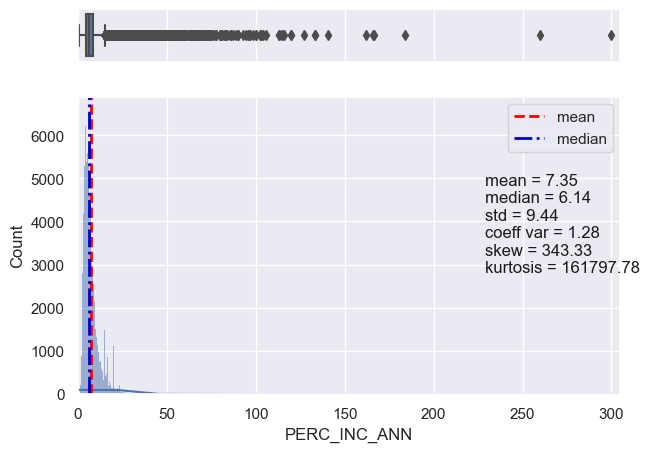

In [79]:
distri(train, 'PERC_INC_ANN', xlim=[0, 305])

In [80]:
detect_outliers(train, 'PERC_INC_ANN', n=1, method='iqr').head(5)[
    col_revenu + ['TARGET', 'PERC_INC_CRED', 'PERC_INC_ANN', 'NAME_INCOME_TYPE', 'OCCUPATION_TYPE',
                  'ORGANIZATION_TYPE']]

,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,TARGET,PERC_INC_CRED,PERC_INC_ANN,NAME_INCOME_TYPE,OCCUPATION_TYPE,ORGANIZATION_TYPE
12840,117000000.0,562491.0,26194.5,454500.0,1,208.003326,4466.586426,Working,Laborers,Business Entity Type 3
258773,2700000.0,180000.0,9000.0,180000.0,0,15.000000,300.000000,Working,Managers,Police
203693,18000090.0,675000.0,69295.5,675000.0,0,26.666800,259.758423,Commercial associate,Unknown,Business Entity Type 3
1723,1935000.0,269550.0,10534.5,225000.0,0,7.178631,183.682190,Pensioner,Pensioner,Pensioner
120597,1125000.0,135000.0,6750.0,135000.0,0,8.333333,166.666672,Commercial associate,Managers,Trade: type 2


Le client avec le plus haut revenu mensuel gagne plus de 4400 fois le montant de ses annuités. Cela confirme le fait que ce revenu est une valeur aberrante.

Pour détecter et corriger ces valeurs aberrantes, on fixe la condition suivante : AMT_INCOME_TOTAL > 1e7 & PERC_INC_CRED > 20.

In [81]:
train[(train['AMT_INCOME_TOTAL'] > 1e7) & (train['PERC_INC_CRED'] > 20)][
    col_revenu + ['TARGET', 'PERC_INC_CRED', 'PERC_INC_ANN', 'NAME_INCOME_TYPE', 'OCCUPATION_TYPE',
                  'ORGANIZATION_TYPE']]

,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,TARGET,PERC_INC_CRED,PERC_INC_ANN,NAME_INCOME_TYPE,OCCUPATION_TYPE,ORGANIZATION_TYPE
12840,117000000.0,562491.0,26194.5,454500.0,1,208.003326,4466.586426,Working,Laborers,Business Entity Type 3
203693,18000090.0,675000.0,69295.5,675000.0,0,26.666800,259.758423,Commercial associate,Unknown,Business Entity Type 3


In [82]:
# Remplacement des outliers extremes par np.nan

train.loc[(train['AMT_INCOME_TOTAL'] > 1e7) & (train['PERC_INC_CRED'] > 20), ['AMT_INCOME_TOTAL', 'PERC_INC_CRED']] = np.nan

On crée une variable qui compte le nombre de mois que dure le crédit.

In [83]:
train['AMT_MONTHS'] = train['AMT_CREDIT'] / train['AMT_ANNUITY']

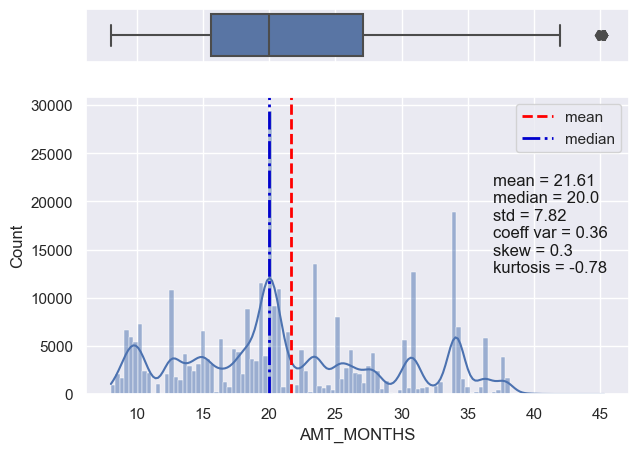

In [84]:
distri(train, 'AMT_MONTHS')

In [85]:
detect_outliers(train, 'AMT_MONTHS', n=1, method='iqr').head(7)[
    col_revenu + ['TARGET', 'PERC_INC_CRED', 'PERC_INC_ANN', 'NAME_INCOME_TYPE', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE', 'AMT_MONTHS']]

,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,TARGET,PERC_INC_CRED,PERC_INC_ANN,NAME_INCOME_TYPE,OCCUPATION_TYPE,ORGANIZATION_TYPE,AMT_MONTHS
202366,94500.0,558000.0,12316.5,558000.0,0,0.169355,7.672634,State servant,Core staff,Other,45.305080
85632,54000.0,486000.0,10728.0,486000.0,0,0.111111,5.033557,State servant,Medicine staff,Medicine,45.302013
62194,112500.0,1008000.0,22252.5,1008000.0,0,0.111607,5.055612,Working,Medicine staff,Business Entity Type 3,45.298283
45179,90000.0,1107000.0,24439.5,1107000.0,1,0.081301,3.682563,Working,Laborers,Business Entity Type 2,45.295525
69092,112500.0,1903500.0,42025.5,1903500.0,1,0.059102,2.676946,Pensioner,Pensioner,Pensioner,45.293930
254181,166500.0,1494000.0,32985.0,1494000.0,0,0.111446,5.047749,Working,Laborers,Restaurant,45.293316
158579,495000.0,2295000.0,50670.0,2295000.0,0,0.215686,9.769094,Commercial associate,Unknown,Bank,45.293072


Les crédits les plus longs durent 45 mois. Cela ne correspond pas à des valeurs aberrantes.

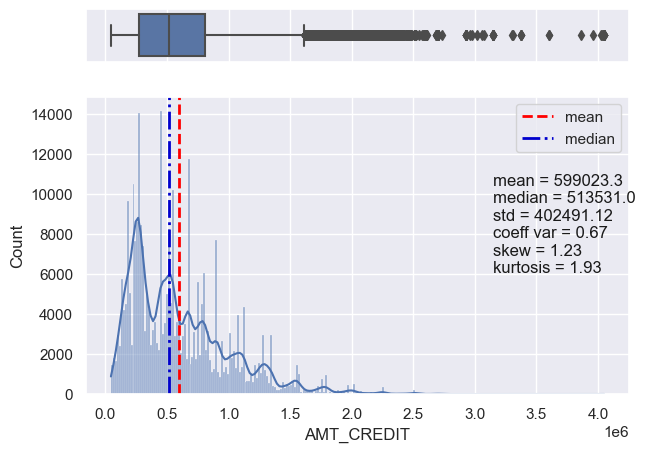

In [86]:
distri(train, 'AMT_CREDIT')

In [87]:
detect_outliers(train, 'AMT_CREDIT', n=1, method='iqr').head(10)[
    col_revenu + ['TARGET', 'PERC_INC_CRED', 'PERC_INC_ANN', 'NAME_INCOME_TYPE', 'OCCUPATION_TYPE',
                  'ORGANIZATION_TYPE']]

,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,TARGET,PERC_INC_CRED,PERC_INC_ANN,NAME_INCOME_TYPE,OCCUPATION_TYPE,ORGANIZATION_TYPE
287732,405000.0,4050000.0,102514.5,4050000.0,0,0.100000,3.950661,Commercial associate,Accountants,Business Entity Type 3
120757,587250.0,4050000.0,106969.5,4050000.0,0,0.145000,5.489882,Commercial associate,Unknown,Industry: type 1
119681,931365.0,4050000.0,102514.5,4050000.0,0,0.229967,9.085202,Commercial associate,Managers,Transport: type 4
288455,450000.0,4050000.0,106839.0,4050000.0,0,0.111111,4.211945,Commercial associate,Managers,Business Entity Type 3
14852,760846.5,4050000.0,146002.5,4050000.0,0,0.187863,5.211188,Commercial associate,Managers,Trade: type 7
17948,783000.0,4050000.0,258025.5,4050000.0,0,0.193333,3.034584,Commercial associate,Managers,Industry: type 4
133766,1307587.5,4050000.0,100197.0,4050000.0,0,0.322861,13.050166,Commercial associate,Managers,Trade: type 2
110459,864900.0,4050000.0,102384.0,4050000.0,0,0.213556,8.447609,Commercial associate,Managers,Business Entity Type 3
95571,430650.0,4031032.5,102033.0,3712500.0,0,0.106834,4.220693,Working,Managers,Business Entity Type 3
186230,458550.0,4027680.0,106380.0,3600000.0,1,0.113850,4.310491,Commercial associate,Unknown,Business Entity Type 3


Les montants des crédits les plus élevés sont de plusieurs millions. La plupart des clients sont Managers. Ces montants sont atypiques mais pas aberrants.

On crée une variable qui calcule la part que prend l'assurance du crédit par rapport au montant de ce dernier.

In [88]:
train['PERC_INSURANCE_CRED'] = (train['AMT_CREDIT'] - train['AMT_GOODS_PRICE']) / train['AMT_CREDIT']

In [89]:
print(train[train['PERC_INSURANCE_CRED'] < 0].shape[0])
train[train['PERC_INSURANCE_CRED'] < 0][col_revenu + ['NAME_CONTRACT_TYPE', 'PERC_INSURANCE_CRED', 'TARGET']].head(10)

260


,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_CONTRACT_TYPE,PERC_INSURANCE_CRED,TARGET
1942,540000.0,315000.0,15750.0,450000.0,Revolving loans,-0.428571,0
2138,112500.0,135000.0,6750.0,202500.0,Revolving loans,-0.500000,0
2808,189000.0,337500.0,16875.0,540000.0,Revolving loans,-0.600000,0
3769,112500.0,135000.0,6750.0,382500.0,Revolving loans,-1.833333,0
4179,436500.0,450000.0,22500.0,900000.0,Revolving loans,-1.000000,0
4858,67500.0,157500.0,7875.0,202500.0,Revolving loans,-0.285714,0
5838,157500.0,157500.0,7875.0,180000.0,Revolving loans,-0.142857,0
6654,112500.0,225000.0,11250.0,337500.0,Revolving loans,-0.500000,0
11372,180000.0,675000.0,33750.0,1350000.0,Revolving loans,-1.000000,0
12420,315000.0,540000.0,27000.0,900000.0,Revolving loans,-0.666667,0


In [90]:
train[train['PERC_INSURANCE_CRED'] < 0]['NAME_CONTRACT_TYPE'].unique()

array(['Revolving loans'], dtype=object)

260 crédits de type "Revolving loans" ont un montant d'assurance négatif. On remplace ces valeurs par 0.

In [91]:
train.loc[train['PERC_INSURANCE_CRED'] < 0, 'PERC_INSURANCE_CRED'] = 0

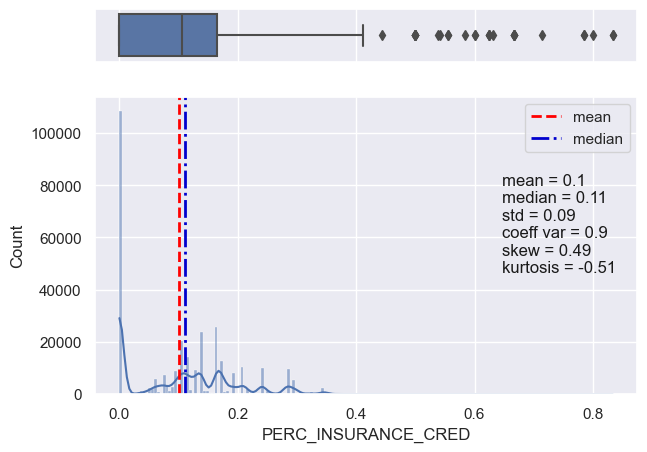

In [92]:
distri(train, 'PERC_INSURANCE_CRED')

In [93]:
detect_outliers(train, 'PERC_INSURANCE_CRED', n=1, method='iqr')[col_revenu + ['NAME_CONTRACT_TYPE', 'PERC_INSURANCE_CRED', 'TARGET']].head(10)

,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_CONTRACT_TYPE,PERC_INSURANCE_CRED,TARGET
167370,202500.0,270000.0,13500.0,45000.0,Revolving loans,0.833333,0
40302,202500.0,270000.0,13500.0,45000.0,Revolving loans,0.833333,0
241021,180000.0,675000.0,33750.0,135000.0,Revolving loans,0.800000,0
226807,81000.0,315000.0,15750.0,67500.0,Revolving loans,0.785714,0
75080,225000.0,630000.0,31500.0,135000.0,Revolving loans,0.785714,0
12139,168750.0,315000.0,15750.0,90000.0,Revolving loans,0.714286,0
288401,135000.0,135000.0,6750.0,45000.0,Revolving loans,0.666667,0
42864,225000.0,337500.0,16875.0,112500.0,Revolving loans,0.666667,0
169894,202500.0,270000.0,13500.0,90000.0,Revolving loans,0.666667,0
40074,112500.0,270000.0,13500.0,90000.0,Revolving loans,0.666667,0


On crée des variables supplémentaires liées aux revenus.

In [94]:
train['INCOME_PER_MEMBER'] = train['AMT_INCOME_TOTAL'] / train['CNT_FAM_MEMBERS']
train['INCOME_PER_CHILD'] = train['AMT_INCOME_TOTAL'] / (train['CNT_CHILDREN'] + 1)

#### <span style='background :#cdcdfc' > Variables temporelles </span>

In [95]:
col_days = [col for col in train.columns if col.startswith('DAYS_')]
col_days

['DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'DAYS_LAST_PHONE_CHANGE']

In [96]:
percentile_report(train, col_days)

,0%,1.0%,5.0%,10.0%,25.0%,50.0%,75.0%,90.0%,95.0%,99.0%,100%
DAYS_BIRTH,-25229.0,-24419.00,-23204.00,-22181.0,-19682.00,-15750.0,-12413.0,-10284.3,-9407.0,-8263.0,-7489.0
DAYS_EMPLOYED,-17912.0,-10894.97,-6742.85,-4881.0,-2760.00,-1213.0,-289.0,365243.0,365243.0,365243.0,365243.0
DAYS_REGISTRATION,-24672.0,-13879.00,-11416.00,-9932.0,-7479.25,-4504.0,-2010.0,-690.0,-330.0,-50.0,0.0
DAYS_ID_PUBLISH,-7197.0,-5447.00,-4944.00,-4724.0,-4299.00,-3254.0,-1720.0,-730.0,-375.0,-61.0,0.0
DAYS_LAST_PHONE_CHANGE,-4292.0,-3149.00,-2522.00,-2158.0,-1570.00,-757.0,-274.0,0.0,0.0,0.0,0.0


In [97]:
percentile_report(train[col_days] / -365, col_days)

,0%,1.0%,5.0%,10.0%,25.0%,50.0%,75.0%,90.0%,95.0%,99.0%,100%
DAYS_BIRTH,20.517808,22.638356,25.772603,28.176164,34.008219,43.150685,53.923288,60.769863,63.572603,66.901370,69.120548
DAYS_EMPLOYED,-1000.665753,-1000.665753,-1000.665753,-1000.665753,0.791781,3.323288,7.561644,13.372603,18.473562,29.849233,49.073973
DAYS_REGISTRATION,0.000000,0.136986,0.904110,1.890411,5.506849,12.339726,20.491096,27.210958,31.276712,38.024658,67.594521
DAYS_ID_PUBLISH,0.000000,0.167123,1.027397,2.000000,4.712329,8.915068,11.778082,12.942466,13.545205,14.923288,19.717808
DAYS_LAST_PHONE_CHANGE,0.000000,0.000000,0.000000,0.000000,0.750685,2.073973,4.301370,5.912329,6.909589,8.627398,11.758904


On remarque que le minimum de la variable "DAYS_EMPLOYED" est de -1000 ans. Cette valeur est aberrante.

In [98]:
train[(train['DAYS_EMPLOYED'] / -365) < 0]['NAME_INCOME_TYPE'].value_counts()

Pensioner     55352
Unemployed       22
Name: NAME_INCOME_TYPE, dtype: int64

Seuls les retraités et clients sans emploi ont des valeurs négatives pour cette variable.

In [99]:
train[(train['DAYS_EMPLOYED'] / -365) == 0]['NAME_INCOME_TYPE'].value_counts()

Working    2
Name: NAME_INCOME_TYPE, dtype: int64

2 clients ont une valeur égale à 0 pour cette variable.

On remplace ces valeurs aberrantes par le nombre moyen de jours travaillés (période de 40 ans) pour un retraité et par le nombre de jours moyen (20 semaines) avant de retrouver un emploi. ([source](https://www.bls.gov/news.release/empsit.t12.htm))

In [100]:
train.loc[train['DAYS_EMPLOYED'] == 0, 'DAYS_EMPLOYED'] = -1

train.loc[train['NAME_INCOME_TYPE'] == 'Pensioner', 'DAYS_EMPLOYED'] = 40 * 365
train.loc[train['NAME_INCOME_TYPE'] == 'Unemployed', 'DAYS_EMPLOYED'] = 20 * 7

In [101]:
percentile_report(train, col_days)

,0%,1.0%,5.0%,10.0%,25.0%,50.0%,75.0%,90.0%,95.0%,99.0%,100%
DAYS_BIRTH,-25229.0,-24419.00,-23204.0,-22181.0,-19682.00,-15750.0,-12413.0,-10284.3,-9407.0,-8263.0,-7489.0
DAYS_EMPLOYED,-17912.0,-10892.94,-6740.0,-4880.0,-2760.00,-1213.0,-289.0,14600.0,14600.0,14600.0,14600.0
DAYS_REGISTRATION,-24672.0,-13879.00,-11416.0,-9932.0,-7479.25,-4504.0,-2010.0,-690.0,-330.0,-50.0,0.0
DAYS_ID_PUBLISH,-7197.0,-5447.00,-4944.0,-4724.0,-4299.00,-3254.0,-1720.0,-730.0,-375.0,-61.0,0.0
DAYS_LAST_PHONE_CHANGE,-4292.0,-3149.00,-2522.0,-2158.0,-1570.00,-757.0,-274.0,0.0,0.0,0.0,0.0


On crée différentes variables liées aux variables temporelles.

In [102]:
train['DAYS_EMPLOYED_PERC'] = train['DAYS_EMPLOYED'] / train['DAYS_BIRTH']
train['ID_TO_BIRTH_RATIO'] = train['DAYS_ID_PUBLISH'] / train['DAYS_BIRTH']
train['CAR_TO_BIRTH_RATIO'] = train['OWN_CAR_AGE'] / (train['DAYS_BIRTH'] / -365)
train['PHONE_TO_BIRTH_RATIO'] = train['DAYS_LAST_PHONE_CHANGE'] / train['DAYS_BIRTH']
train['INCOME_TO_BIRTH_RATIO'] = - train['AMT_INCOME_TOTAL'] / train['DAYS_BIRTH']
train['AGE_END'] = train['AMT_MONTHS'] / 12 + (train['DAYS_BIRTH'] / -365)

train['INCOME_TO_EMPLOYED_RATIO'] = - train['AMT_INCOME_TOTAL'] / train['DAYS_EMPLOYED']
train['CAR_TO_EMPLOYED_RATIO'] = train['OWN_CAR_AGE'] / (train['DAYS_EMPLOYED'] / -365)

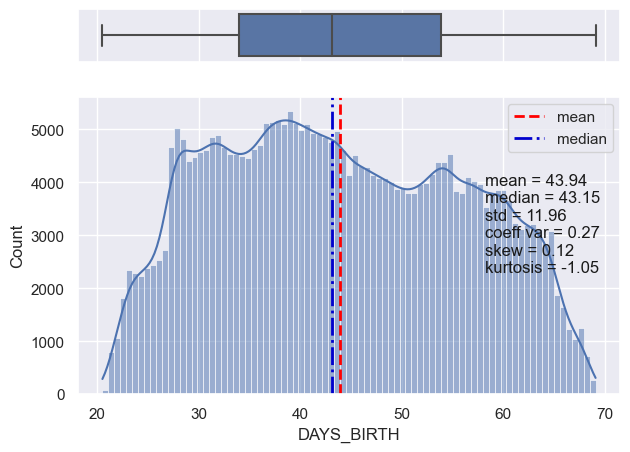

In [103]:
distri(train[['DAYS_BIRTH']] / -365, 'DAYS_BIRTH')

In [104]:
def get_age_label(days_birth):
    """ Return the age group label (int). """
    age_years = -days_birth / 365
    if age_years < 27: return 1
    elif age_years < 40: return 2
    elif age_years < 50: return 3
    elif age_years < 60: return 4
    elif age_years < 99: return 5
    else: return 0

In [105]:
train['AGE_RANGE'] = train['DAYS_BIRTH'].apply(lambda x: get_age_label(x))

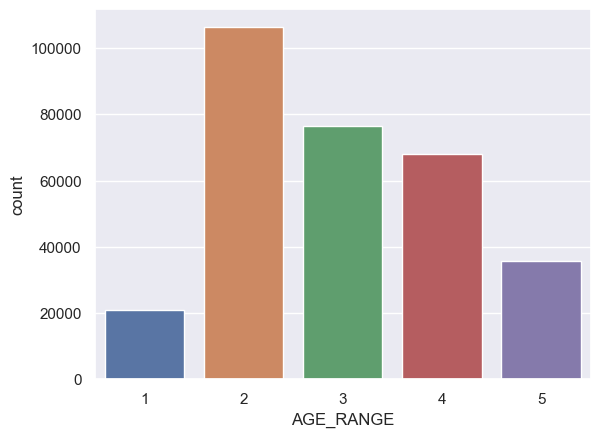

In [106]:
sns.countplot(train, x= 'AGE_RANGE');

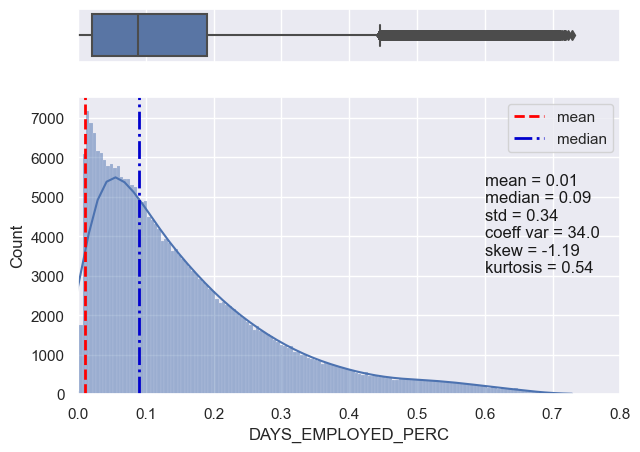

In [107]:
distri(train, 'DAYS_EMPLOYED_PERC', xlim=[0, 0.8])

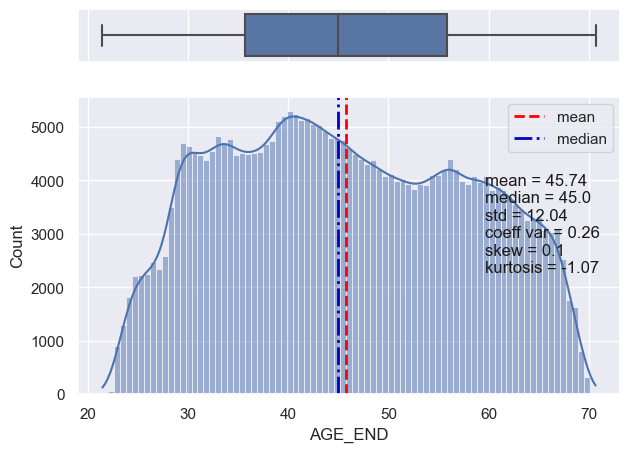

In [108]:
distri(train, 'AGE_END')

#### <span style='background :#cdcdfc' > Variables CREDIT_BUREAU </span>

In [109]:
col_cred_bur = [f for f in list_col if f.startswith('AMT_REQ')]
col_cred_bur

['AMT_REQ_CREDIT_BUREAU_HOUR',
 'AMT_REQ_CREDIT_BUREAU_DAY',
 'AMT_REQ_CREDIT_BUREAU_WEEK',
 'AMT_REQ_CREDIT_BUREAU_MON',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'AMT_REQ_CREDIT_BUREAU_YEAR']

In [110]:
percentile_report(train, col_cred_bur)

,0%,1.0%,5.0%,10.0%,25.0%,50.0%,75.0%,90.0%,95.0%,99.0%,100%
AMT_REQ_CREDIT_BUREAU_HOUR,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
AMT_REQ_CREDIT_BUREAU_DAY,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0
AMT_REQ_CREDIT_BUREAU_WEEK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,8.0
AMT_REQ_CREDIT_BUREAU_MON,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,4.0,27.0
AMT_REQ_CREDIT_BUREAU_QRT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,2.0,261.0
AMT_REQ_CREDIT_BUREAU_YEAR,0.0,0.0,0.0,0.0,0.0,1.0,3.0,4.0,6.0,8.0,25.0


On remarque des valeurs aberrantes pour la variable "AMT_REQ_CREDIT_BUREAU_QRT" qui compte le nombre de demandes de renseignements concernant le client adressées au Bureau de crédit 3 mois avant la demande (sauf un mois avant la demande).

In [111]:
detect_outliers(train, 'AMT_REQ_CREDIT_BUREAU_QRT', n=1, method='iqr')[
    col_revenu + col_cred_bur + ['TARGET']].head(10)

,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,TARGET
239474,360000.0,1035000.0,30393.0,1035000.0,0.0,0.0,0.0,1.0,261.0,0.0,0
253541,202500.0,675000.0,34596.0,675000.0,0.0,0.0,0.0,0.0,19.0,2.0,1
289714,270000.0,389043.0,30235.5,333000.0,0.0,0.0,0.0,1.0,8.0,2.0,0
3770,202500.0,137538.0,14724.0,121500.0,0.0,0.0,0.0,0.0,8.0,0.0,0
195971,450000.0,1350000.0,67500.0,1350000.0,0.0,0.0,0.0,0.0,8.0,0.0,0
62052,157500.0,270000.0,32040.0,270000.0,0.0,0.0,0.0,0.0,8.0,2.0,0
16194,450000.0,545040.0,25537.5,450000.0,0.0,0.0,0.0,0.0,8.0,5.0,0
257728,256500.0,540000.0,22698.0,540000.0,0.0,0.0,0.0,0.0,8.0,2.0,0
127569,202500.0,1323000.0,47650.5,1323000.0,0.0,0.0,0.0,0.0,8.0,5.0,0
11326,90000.0,539230.5,27697.5,409500.0,0.0,0.0,0.0,0.0,7.0,1.0,0


On fixe le maximum de la variable à "AMT_REQ_CREDIT_BUREAU_QRT" à 30, ce qui correspond à une demande de renseignement tous les 2 jours.

In [112]:
train.loc[train['AMT_REQ_CREDIT_BUREAU_QRT'] > 30, 'AMT_REQ_CREDIT_BUREAU_QRT'] = 30

On liste les variables dont le mode occupe plus de 94 % des prêts.

In [113]:
col_to_del = compute_mode_percentage(train, col_cred_bur, threshold=0.94)

                       Column  Mode  Mode_pct
5  AMT_REQ_CREDIT_BUREAU_YEAR   0.0  0.269935
4   AMT_REQ_CREDIT_BUREAU_QRT   0.0  0.809861
3   AMT_REQ_CREDIT_BUREAU_MON   0.0  0.835486
2  AMT_REQ_CREDIT_BUREAU_WEEK   0.0  0.967909
0  AMT_REQ_CREDIT_BUREAU_HOUR   0.0  0.993887
1   AMT_REQ_CREDIT_BUREAU_DAY   0.0  0.994402

Liste des features à supprimer :
['AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK']


On supprime ces variables.

In [114]:
train.drop(columns=col_to_del, inplace=True)

#### <span style='background :#cdcdfc' > Variables SOCIAL_CIRCLE </span>

In [115]:
col_social = [f for f in train.columns if f.endswith('_SOCIAL_CIRCLE')]
col_social

['OBS_30_CNT_SOCIAL_CIRCLE',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'DEF_60_CNT_SOCIAL_CIRCLE']

In [116]:
percentile_report(train, col_social)

,0%,1.0%,5.0%,10.0%,25.0%,50.0%,75.0%,90.0%,95.0%,99.0%,100%
OBS_30_CNT_SOCIAL_CIRCLE,0.0,0.0,0.0,0.0,0.0,0.0,2.0,4.0,6.0,10.0,348.0
DEF_30_CNT_SOCIAL_CIRCLE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,34.0
OBS_60_CNT_SOCIAL_CIRCLE,0.0,0.0,0.0,0.0,0.0,0.0,2.0,4.0,6.0,10.0,344.0
DEF_60_CNT_SOCIAL_CIRCLE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,24.0


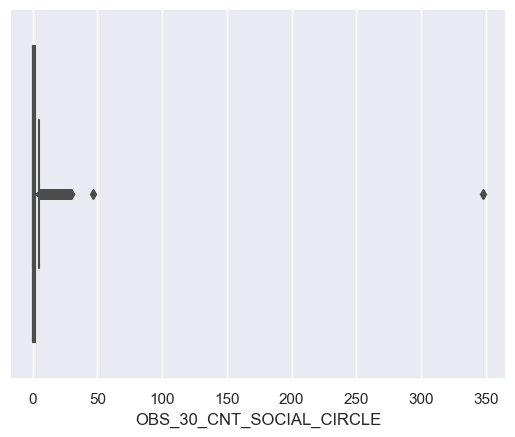

In [117]:
sns.boxplot(x=train['OBS_30_CNT_SOCIAL_CIRCLE']);

In [118]:
detect_outliers(train, 'OBS_30_CNT_SOCIAL_CIRCLE', n=1, method='iqr')[col_social + ['TARGET']].head(10)

,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,TARGET
148403,348.0,34.0,344.0,24.0,0
77497,47.0,0.0,47.0,0.0,0
169517,30.0,0.0,30.0,0.0,0
280641,30.0,0.0,29.0,0.0,1
56170,29.0,0.0,29.0,0.0,0
33480,28.0,0.0,28.0,0.0,0
68096,27.0,0.0,27.0,0.0,0
131200,27.0,0.0,27.0,0.0,0
90035,27.0,1.0,27.0,0.0,0
114543,27.0,1.0,27.0,0.0,0


In [119]:
train.loc[train['OBS_30_CNT_SOCIAL_CIRCLE'] > 100, 'OBS_30_CNT_SOCIAL_CIRCLE'] = np.nan

#### <span style='background :#cdcdfc' > Autres variables </span>

In [120]:
col_other = sorted(list(set(list_col) - set(col_revenu + col_days + col_cred_bur + col_social + list_var_categ + list_var_binaire)))
col_other = [x for x in col_other if x not in ['SK_ID_CURR', 'TARGET']]
col_other

['CNT_CHILDREN',
 'CNT_DOC',
 'CNT_FAM_MEMBERS',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'HOUR_APPR_PROCESS_START',
 'OWN_CAR_AGE',
 'REGION_POPULATION_RELATIVE',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY']

In [121]:
col_to_del = compute_mode_percentage(train, col_other, threshold=0.94)

                         Column       Mode  Mode_pct
3                  EXT_SOURCE_1   0.356323  0.000037
4                  EXT_SOURCE_2   0.285898  0.002350
5                  EXT_SOURCE_3   0.746300  0.005922
8    REGION_POPULATION_RELATIVE   0.035792  0.053359
7                   OWN_CAR_AGE   7.000000  0.070988
6       HOUR_APPR_PROCESS_START  10.000000  0.122672
2               CNT_FAM_MEMBERS   2.000000  0.514972
0                  CNT_CHILDREN   0.000000  0.700375
9          REGION_RATING_CLIENT   2.000000  0.738133
10  REGION_RATING_CLIENT_W_CITY   2.000000  0.746263
1                       CNT_DOC   1.000000  0.878210

Liste des features à supprimer :
[]


In [122]:
percentile_report(train, col_other)

,0%,1.0%,5.0%,10.0%,25.0%,50.0%,75.0%,90.0%,95.0%,99.0%,100%
CNT_CHILDREN,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000,2.000000,3.000000,19.000000
CNT_DOC,0.000000e+00,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,4.000000
CNT_FAM_MEMBERS,1.000000e+00,1.000000,1.000000,1.000000,2.000000,2.000000,3.000000,3.000000,4.000000,5.000000,20.000000
EXT_SOURCE_1,1.456813e-02,0.084256,0.158020,0.212498,0.334006,0.505993,0.675051,0.786659,0.832259,0.889402,0.962693
EXT_SOURCE_2,8.173617e-08,0.029476,0.133299,0.215690,0.392455,0.565959,0.663617,0.722047,0.747737,0.782793,0.855000
EXT_SOURCE_3,5.272652e-04,0.064672,0.154744,0.227613,0.370650,0.535276,0.669057,0.749022,0.786267,0.832785,0.896010
HOUR_APPR_PROCESS_START,0.000000e+00,4.000000,7.000000,8.000000,10.000000,12.000000,14.000000,16.000000,17.000000,19.000000,23.000000
OWN_CAR_AGE,0.000000e+00,0.000000,1.000000,2.000000,5.000000,9.000000,15.000000,22.000000,30.000000,64.000000,91.000000
REGION_POPULATION_RELATIVE,2.900000e-04,0.002134,0.004960,0.006629,0.010006,0.018850,0.028663,0.035792,0.046220,0.072508,0.072508
REGION_RATING_CLIENT,1.000000e+00,1.000000,1.000000,1.000000,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,3.000000


Pas de valeurs aberrantes dans les variables restantes.

<br>

---

### <span style='background :#e3e33d' > 3.4 Corrélations </span>

On s'intéresse maintenant aux corrélations entre variables.

In [123]:
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,INCOME_PER_CHILD,DAYS_EMPLOYED_PERC,ID_TO_BIRTH_RATIO,CAR_TO_BIRTH_RATIO,PHONE_TO_BIRTH_RATIO,INCOME_TO_BIRTH_RATIO,AGE_END,INCOME_TO_EMPLOYED_RATIO,CAR_TO_EMPLOYED_RATIO,AGE_RANGE
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,202500.0,0.067329,0.224078,NaN,0.119860,21.403658,27.292307,317.896389,NaN,1
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,270000.0,0.070862,0.017358,NaN,0.049389,16.104980,48.951014,227.272727,NaN,3
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,67500.0,0.011814,0.132889,0.498267,0.042791,3.544051,53.847489,300.000000,42.177778,4
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,135000.0,0.159905,0.128229,NaN,0.032465,7.103394,52.946228,44.422507,NaN,4
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,121500.0,0.152418,0.173490,NaN,0.055489,6.095726,56.563354,39.993417,NaN,4


On liste les variables à analyser.

In [124]:
interval_cols = ['TARGET', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
                 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
                 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH',
                 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE',
                 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START',
                 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
                 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',
                 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE',
                 'DAYS_LAST_PHONE_CHANGE', 'AMT_REQ_CREDIT_BUREAU_MON',
                 'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR', 'CNT_DOC',
                 'PERC_INC_CRED', 'PERC_INC_ANN', 'AMT_MONTHS', 'PERC_INSURANCE_CRED',
                 'INCOME_PER_MEMBER', 'INCOME_PER_CHILD', 'DAYS_EMPLOYED_PERC', 'ID_TO_BIRTH_RATIO',
                 'CAR_TO_BIRTH_RATIO', 'PHONE_TO_BIRTH_RATIO', 'INCOME_TO_BIRTH_RATIO',
                 'AGE_END', 'INCOME_TO_EMPLOYED_RATIO', 'CAR_TO_EMPLOYED_RATIO']

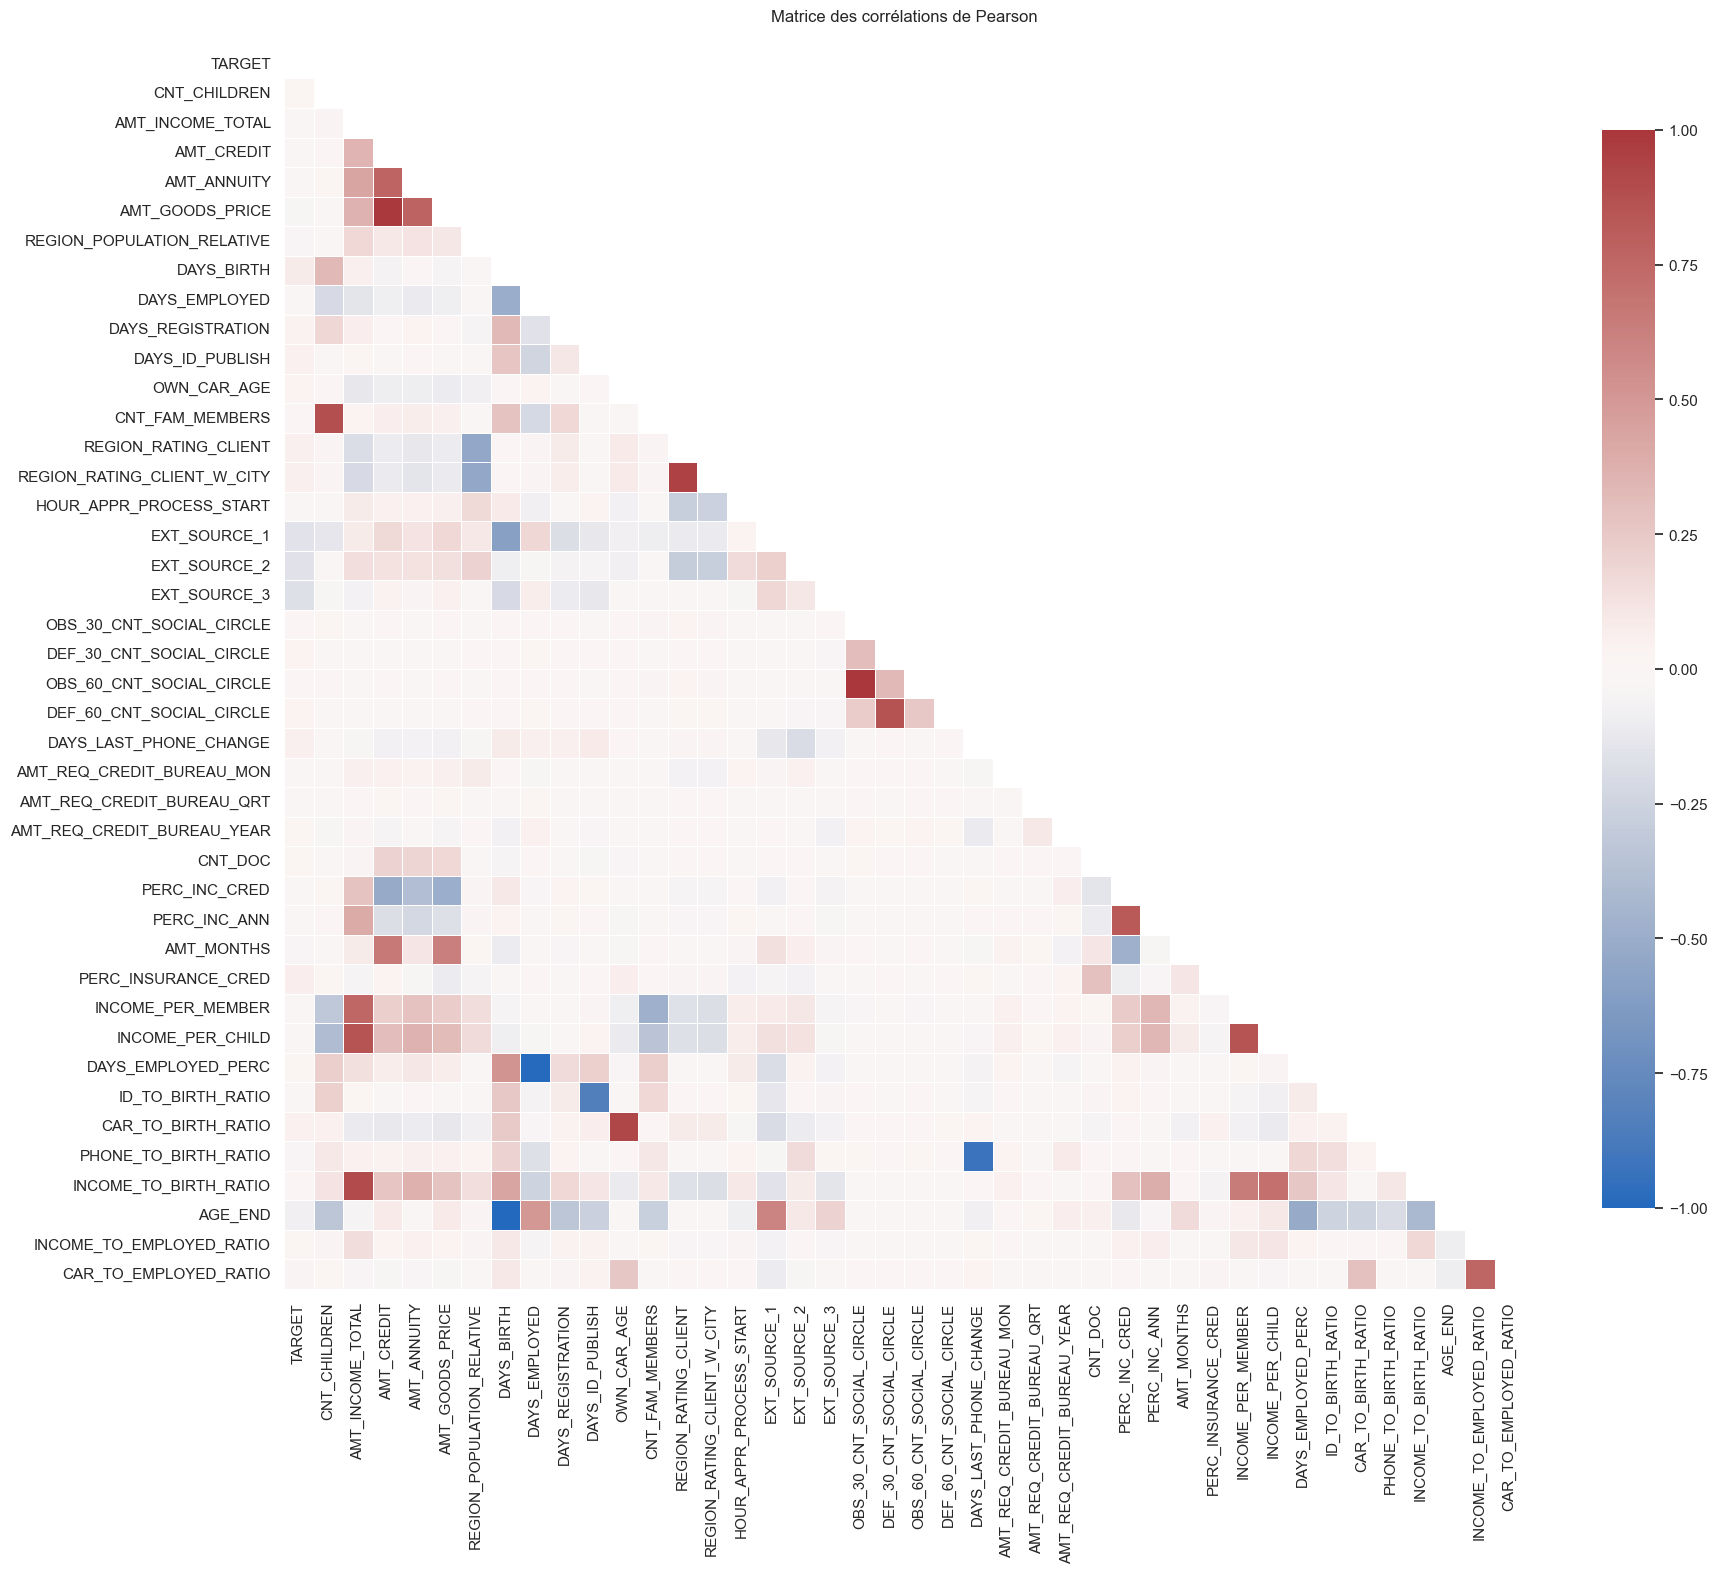

In [125]:
correlation = train[interval_cols].corr()
# # Heatmap de la matrice de corrélation

sns.set_style("whitegrid")

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(correlation, dtype=bool))

# Set up the matplotlib figure
plt.subplots(figsize=(20, 20))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation, mask=mask, annot=False, cmap="vlag", vmin=-1, vmax=1, center=0, square=True, linewidths=.5,
            cbar_kws={"shrink": 0.7})

plt.title("Matrice des corrélations de Pearson")
plt.show()

On observe plusieurs cas de multicolinéarité notamment entre les variables liées au montant du crédit ("AMT_CREDIT", "AMT_GOODS_PRICE", "AMT_ANNUITY" etc) ou des revenus. La multicolinéarité sera traitée lors de la sélection des features.

In [126]:
abs(train[interval_cols].corr()['TARGET'].sort_values()).sort_values(ascending=False)

TARGET                         1.000000
EXT_SOURCE_3                   0.178918
EXT_SOURCE_2                   0.160452
EXT_SOURCE_1                   0.155333
AGE_END                        0.079407
DAYS_BIRTH                     0.078233
PERC_INSURANCE_CRED            0.068484
REGION_RATING_CLIENT_W_CITY    0.060873
REGION_RATING_CLIENT           0.058880
DAYS_LAST_PHONE_CHANGE         0.055227
DAYS_ID_PUBLISH                0.051455
CAR_TO_BIRTH_RATIO             0.048838
DAYS_REGISTRATION              0.041949
AMT_GOODS_PRICE                0.039670
OWN_CAR_AGE                    0.037626
REGION_POPULATION_RELATIVE     0.037225
PHONE_TO_BIRTH_RATIO           0.034000
DEF_30_CNT_SOCIAL_CIRCLE       0.032230
AMT_MONTHS                     0.032147
DEF_60_CNT_SOCIAL_CIRCLE       0.031252
CAR_TO_EMPLOYED_RATIO          0.030646
AMT_CREDIT                     0.030388
INCOME_PER_CHILD               0.024498
HOUR_APPR_PROCESS_START        0.024162
DAYS_EMPLOYED                  0.022292


Les variables "EXT_SOURCE" sont les plus corrélées à la target.

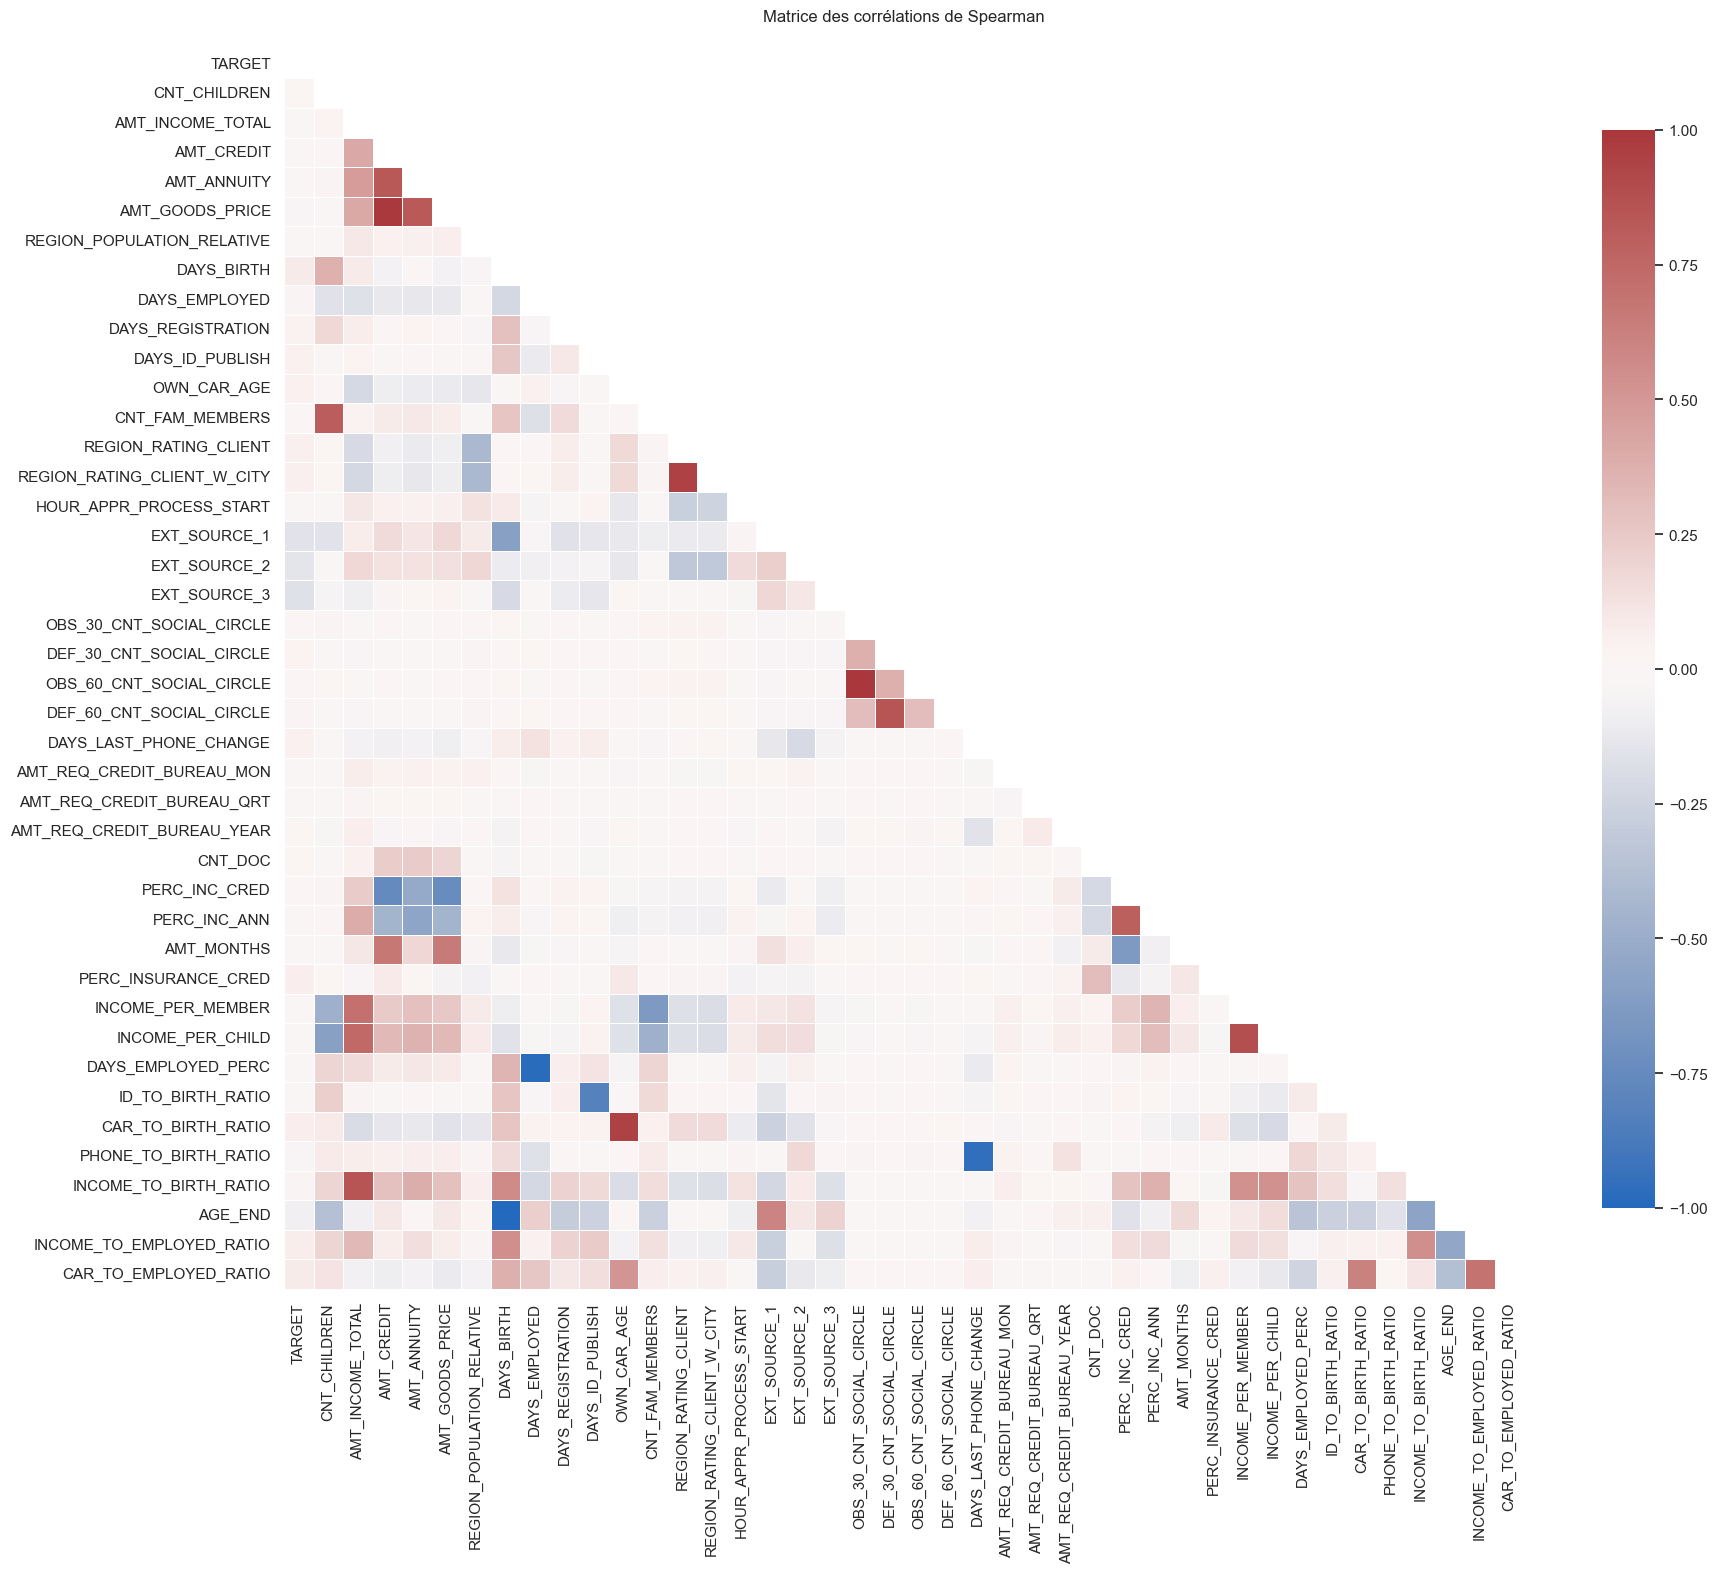

In [127]:
correlation = train[interval_cols].corr(method='spearman')
# # Heatmap de la matrice de corrélation

sns.set_style("whitegrid")

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(correlation, dtype=bool))

# Set up the matplotlib figure
plt.subplots(figsize=(20, 20))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation, mask=mask, annot=False, cmap="vlag", vmin=-1, vmax=1, center=0, square=True, linewidths=.5,
            cbar_kws={"shrink": 0.7})

plt.title("Matrice des corrélations de Spearman")
plt.show()

In [128]:
abs(train[interval_cols].corr(method='spearman')['TARGET']).sort_values(ascending=False)

TARGET                         1.000000
EXT_SOURCE_3                   0.166330
EXT_SOURCE_1                   0.151146
EXT_SOURCE_2                   0.147310
CAR_TO_EMPLOYED_RATIO          0.081634
AGE_END                        0.079556
DAYS_BIRTH                     0.078322
INCOME_TO_EMPLOYED_RATIO       0.071991
PERC_INSURANCE_CRED            0.066812
CAR_TO_BIRTH_RATIO             0.066572
REGION_RATING_CLIENT_W_CITY    0.060916
REGION_RATING_CLIENT           0.058890
DAYS_LAST_PHONE_CHANGE         0.053714
OWN_CAR_AGE                    0.052942
DAYS_ID_PUBLISH                0.052534
DAYS_REGISTRATION              0.040141
PHONE_TO_BIRTH_RATIO           0.035891
DEF_30_CNT_SOCIAL_CIRCLE       0.032172
AMT_GOODS_PRICE                0.031508
DEF_60_CNT_SOCIAL_CIRCLE       0.030873
REGION_POPULATION_RELATIVE     0.030560
AMT_MONTHS                     0.030304
DAYS_EMPLOYED                  0.025154
INCOME_PER_CHILD               0.025118
INCOME_TO_BIRTH_RATIO          0.024271


Les variables "EXT_SOURCE" sont les plus corrélées à la target.

Pour finir, on utilise le coefficient Phi k qui permet de détecter les corrélations linéaires et non linéaires entre variables de natures différentes.

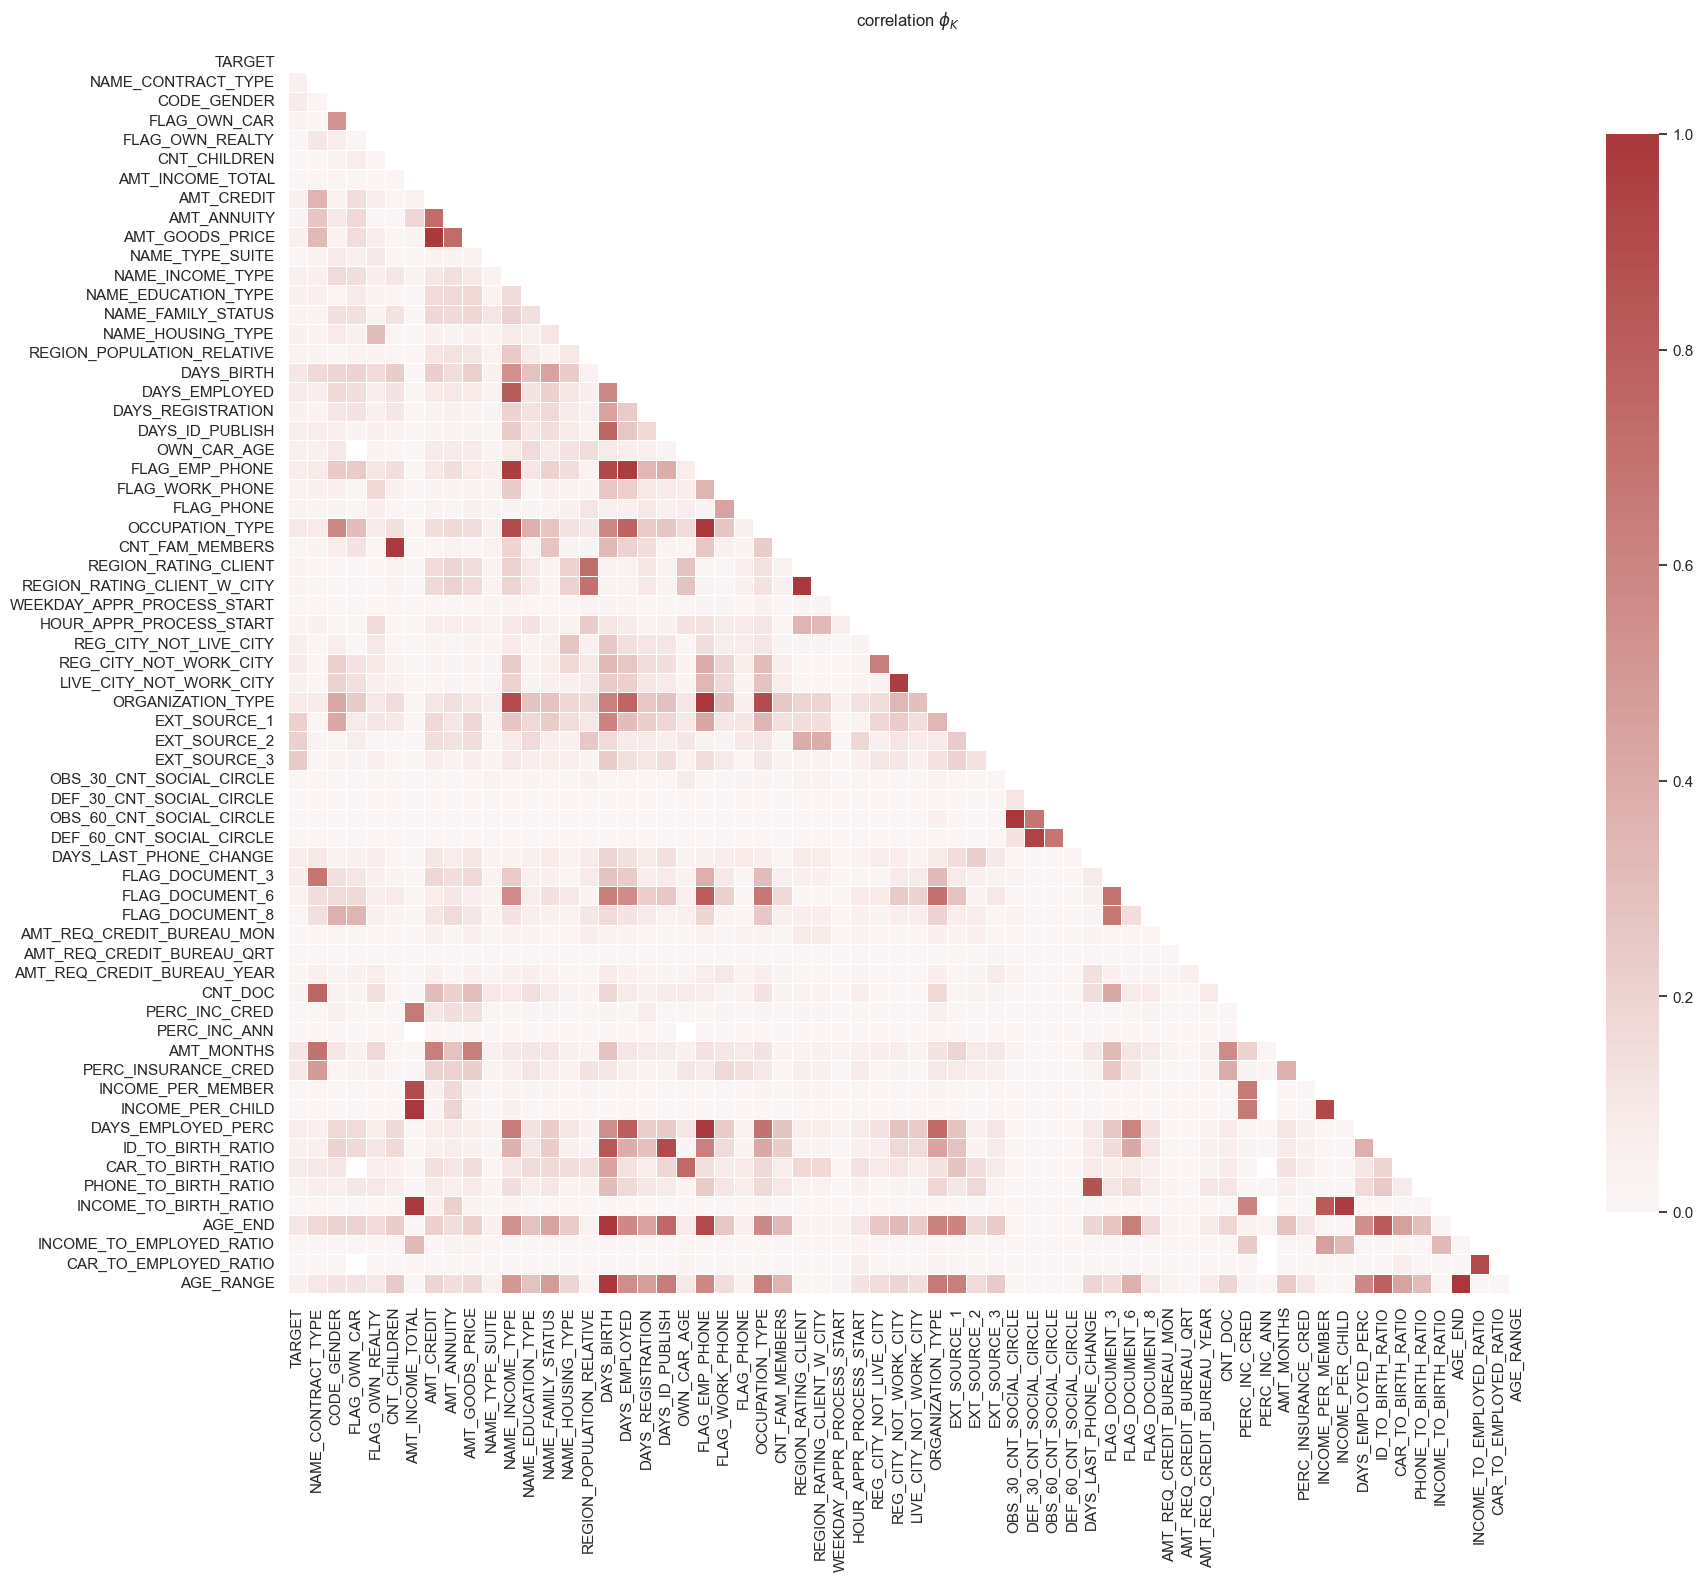

In [129]:
import phik

correlation = train.drop(columns='SK_ID_CURR').phik_matrix(interval_cols=interval_cols)
# # Heatmap de la matrice de corrélation

sns.set_style("whitegrid")

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(correlation, dtype=bool))

# Set up the matplotlib figure
plt.subplots(figsize=(20, 20))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation, mask=mask, annot=False, cmap="vlag", vmin=0, vmax=1, center=0, square=True, linewidths=.5,
            cbar_kws={"shrink": 0.7})

plt.title(r"correlation $\phi_K$")
plt.show()

In [130]:
train.drop(columns='SK_ID_CURR').phik_matrix(interval_cols=interval_cols)['TARGET'].sort_values(ascending=False)

TARGET                      1.000000
EXT_SOURCE_3                0.247679
EXT_SOURCE_1                0.217871
EXT_SOURCE_2                0.213946
AMT_MONTHS                  0.105071
                              ...   
INCOME_PER_CHILD            0.000000
INCOME_PER_MEMBER           0.000000
INCOME_TO_BIRTH_RATIO       0.000000
AMT_INCOME_TOTAL            0.000000
OBS_60_CNT_SOCIAL_CIRCLE    0.000000
Name: TARGET, Length: 64, dtype: float64

Les variables de type "EXT_SOURCE" sont les plus corrélées à la target. Ces variables sont des scores de crédit donnés par un organisme externe.

<br>

---

### <span style='background :#e3e33d' > 3.5 Feature engineering supplémentaire </span>

Comme les variables de type "EXT_SOURCE" font partie des variables les plus corrélées avec la target, nous allons créer de nouvelles variables avec ces dernières.
On utilisera en priorité les variables les plus corrélées avec celles ci et on effectuera des opérations mathématiques basiques comme le ratio ou la multiplication.

Pour chacune des variables "EXT_SOURCE", on dresse la liste des variables les plus corrélées avec le coefficient Phi k.

In [131]:
train[interval_cols].phik_matrix(interval_cols=interval_cols)['EXT_SOURCE_1'].sort_values(ascending=False)

EXT_SOURCE_1                   1.000000
AGE_END                        0.606393
DAYS_BIRTH                     0.604484
DAYS_EMPLOYED                  0.312155
ID_TO_BIRTH_RATIO              0.283179
CAR_TO_BIRTH_RATIO             0.279643
DAYS_EMPLOYED_PERC             0.277281
EXT_SOURCE_2                   0.239180
DAYS_REGISTRATION              0.225434
TARGET                         0.217871
EXT_SOURCE_3                   0.203640
AMT_MONTHS                     0.193512
AMT_GOODS_PRICE                0.181497
DAYS_ID_PUBLISH                0.180990
AMT_CREDIT                     0.175531
REGION_RATING_CLIENT           0.149531
DAYS_LAST_PHONE_CHANGE         0.147425
REGION_RATING_CLIENT_W_CITY    0.146704
CNT_FAM_MEMBERS                0.140352
AMT_ANNUITY                    0.108900
PHONE_TO_BIRTH_RATIO           0.105859
OWN_CAR_AGE                    0.097355
REGION_POPULATION_RELATIVE     0.097073
CNT_CHILDREN                   0.095237
PERC_INSURANCE_CRED            0.084253


In [132]:
train[interval_cols].phik_matrix(interval_cols=interval_cols)['EXT_SOURCE_2'].sort_values(ascending=False)

EXT_SOURCE_2                   1.000000
REGION_RATING_CLIENT           0.394890
REGION_RATING_CLIENT_W_CITY    0.388508
REGION_POPULATION_RELATIVE     0.254082
EXT_SOURCE_1                   0.239180
DAYS_LAST_PHONE_CHANGE         0.221990
TARGET                         0.213946
HOUR_APPR_PROCESS_START        0.185748
PHONE_TO_BIRTH_RATIO           0.179272
AGE_END                        0.164151
DAYS_BIRTH                     0.161023
CAR_TO_BIRTH_RATIO             0.155490
AMT_GOODS_PRICE                0.151500
AMT_CREDIT                     0.145607
AMT_ANNUITY                    0.127901
EXT_SOURCE_3                   0.125037
OWN_CAR_AGE                    0.103085
AMT_MONTHS                     0.091245
DAYS_EMPLOYED                  0.080704
DAYS_REGISTRATION              0.078835
PERC_INSURANCE_CRED            0.076161
DAYS_ID_PUBLISH                0.064543
AMT_REQ_CREDIT_BUREAU_MON      0.058147
DAYS_EMPLOYED_PERC             0.056844
CNT_DOC                        0.040224


In [133]:
train[interval_cols].phik_matrix(interval_cols=interval_cols)['EXT_SOURCE_3'].sort_values(ascending=False)

EXT_SOURCE_3                   1.000000
TARGET                         0.247679
DAYS_BIRTH                     0.236554
AGE_END                        0.235759
EXT_SOURCE_1                   0.203640
DAYS_ID_PUBLISH                0.149120
DAYS_EMPLOYED                  0.135424
EXT_SOURCE_2                   0.125037
DAYS_REGISTRATION              0.116342
DAYS_EMPLOYED_PERC             0.114789
DAYS_LAST_PHONE_CHANGE         0.100132
AMT_MONTHS                     0.095598
AMT_REQ_CREDIT_BUREAU_YEAR     0.088505
CAR_TO_BIRTH_RATIO             0.084538
ID_TO_BIRTH_RATIO              0.082637
AMT_GOODS_PRICE                0.068189
AMT_CREDIT                     0.066170
PERC_INSURANCE_CRED            0.062293
HOUR_APPR_PROCESS_START        0.049519
REGION_RATING_CLIENT_W_CITY    0.044980
OWN_CAR_AGE                    0.044006
REGION_RATING_CLIENT           0.043708
PHONE_TO_BIRTH_RATIO           0.041393
AMT_ANNUITY                    0.035852
CNT_FAM_MEMBERS                0.033594


In [134]:
train['EXT_SOURCE_MEAN'] = train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)
train['EXT_SOURCE_PROD'] = train['EXT_SOURCE_1'] * train['EXT_SOURCE_2'] * train['EXT_SOURCE_3']

train['EXT_SOURCE_1_TO_BIRTH_RATIO'] = train['EXT_SOURCE_1'] / (train['DAYS_BIRTH'] / -365)
train['EXT_SOURCE_1_TO_EMPLOY_RATIO'] = train['EXT_SOURCE_1'] / (train['DAYS_EMPLOYED'] / -365)
train['EXT_SOURCE_1*DAYS_BIRTH'] = train['EXT_SOURCE_1'] * (train['DAYS_BIRTH'] / -365)
train['EXT_SOURCE_1*DAYS_EMPLOYED'] = train['EXT_SOURCE_1'] * (train['DAYS_EMPLOYED'] / -365)

train['EXT_SOURCE_2_TO_BIRTH_RATIO'] = train['EXT_SOURCE_2'] / (train['DAYS_BIRTH'] / -365)
train['EXT_SOURCE_2_TO_EMPLOY_RATIO'] = train['EXT_SOURCE_2'] / (train['DAYS_EMPLOYED'] / -365)
train['EXT_SOURCE_2*DAYS_BIRTH'] = train['EXT_SOURCE_2'] * (train['DAYS_BIRTH'] / -365)
train['EXT_SOURCE_2*DAYS_EMPLOYED'] = train['EXT_SOURCE_2'] * (train['DAYS_EMPLOYED'] / -365)
train['EXT_SOURCE_2_TO_REGION_RATIO'] = train['EXT_SOURCE_2'] / train['REGION_RATING_CLIENT']
train['EXT_SOURCE_2*REGION_RATING_CLIENT'] = train['EXT_SOURCE_2'] * train['REGION_RATING_CLIENT']

train['EXT_SOURCE_3_TO_BIRTH_RATIO'] = train['EXT_SOURCE_3'] / (train['DAYS_BIRTH'] / -365)
train['EXT_SOURCE_3*DAYS_BIRTH'] = train['EXT_SOURCE_3'] * (train['DAYS_BIRTH'] / -365)

train['EXT_SOURCE_1_TO_EXT_SOURCE_2_RATIO'] = train['EXT_SOURCE_1'] / train['EXT_SOURCE_2']
train['EXT_SOURCE_2_TO_EXT_SOURCE_3_RATIO'] = train['EXT_SOURCE_2'] / train['EXT_SOURCE_3']
train['EXT_SOURCE_1_TO_EXT_SOURCE_3_RATIO'] = train['EXT_SOURCE_1'] / train['EXT_SOURCE_3']

train['EXT_SOURCE_1*EXT_SOURCE_2'] = train['EXT_SOURCE_1'] * train['EXT_SOURCE_2']
train['EXT_SOURCE_2*EXT_SOURCE_3'] = train['EXT_SOURCE_2'] * train['EXT_SOURCE_3']
train['EXT_SOURCE_1*EXT_SOURCE_3'] = train['EXT_SOURCE_1'] * train['EXT_SOURCE_3']

<br>

---

### <span style='background :#e3e33d' > 3.6 Information Value </span>

Pour finir l'analyse exploratoire, nous allons calculer pour chacune des variables l'Information Value (IV) qui est une mesure statistique utilisée pour évaluer la force d'un prédicteur.

L'IV permet d'identifier les variables qui contribuent le plus à la séparation entre les deux classes d'intérêt (prêt remboursé ou non).

L'interprétation de l'IV est généralement la suivante:

- IV < 0.02, la variable n'est pas informative et peut être ignorée.
- 0.02 ≤ IV < 0.1, la variable est faiblement informative.
- 0.1 ≤ IV < 0.3, la variable est moyennement informative.
- 0.3 ≤ IV < 0.5, la variable est fortement informative.
- IV ≥ 0.5, la variable est trop fortement informative, cela pourrait indiquer un problème de données.

On commence par s'intéresser aux variables catégorielles et binaires.

In [135]:
IV = iv_woe(train.drop(columns='SK_ID_CURR')[list_var_categ + list_var_binaire + ['AGE_RANGE','TARGET']], 'TARGET', bins=10).sort_values(by='IV', ascending=False)
IV

,Variable,IV
0,OCCUPATION_TYPE,0.096378
0,AGE_RANGE,0.077173
0,ORGANIZATION_TYPE,0.074232
0,NAME_INCOME_TYPE,0.058241
0,NAME_EDUCATION_TYPE,0.050812
0,CODE_GENDER,0.038630
0,FLAG_EMP_PHONE,0.032899
0,REG_CITY_NOT_WORK_CITY,0.032194
0,FLAG_DOCUMENT_3,0.028621
0,REG_CITY_NOT_LIVE_CITY,0.022306


"OCCUPATION_TYPE", "AGE_RANGE", "ORGANIZATION_TYPE", "NAME_INCOME_TYPE" et "NAME_EDUCATION_TYPE" font parties des variables de type catégorielle les plus informatives.
Cela peut s'illustrer en comparant la proportion moyenne de défauts de paiement de chaque modalité pour ces variables.

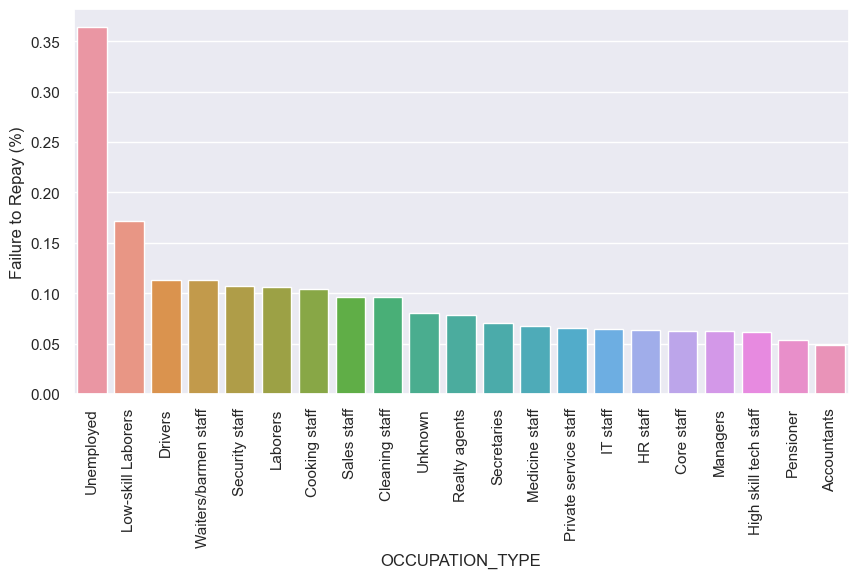

In [136]:
compare_target_categ(train, 'OCCUPATION_TYPE', figsize=(10, 5), rotate=True, order=True)

Les personnes sans emploi ont le taux de défaut de paiement moyen le plus élevé devant les ouvriers peu qualifiés. A contrario, les retraités et comptables ont le taux de défaut de paiement moyen le plus faible.

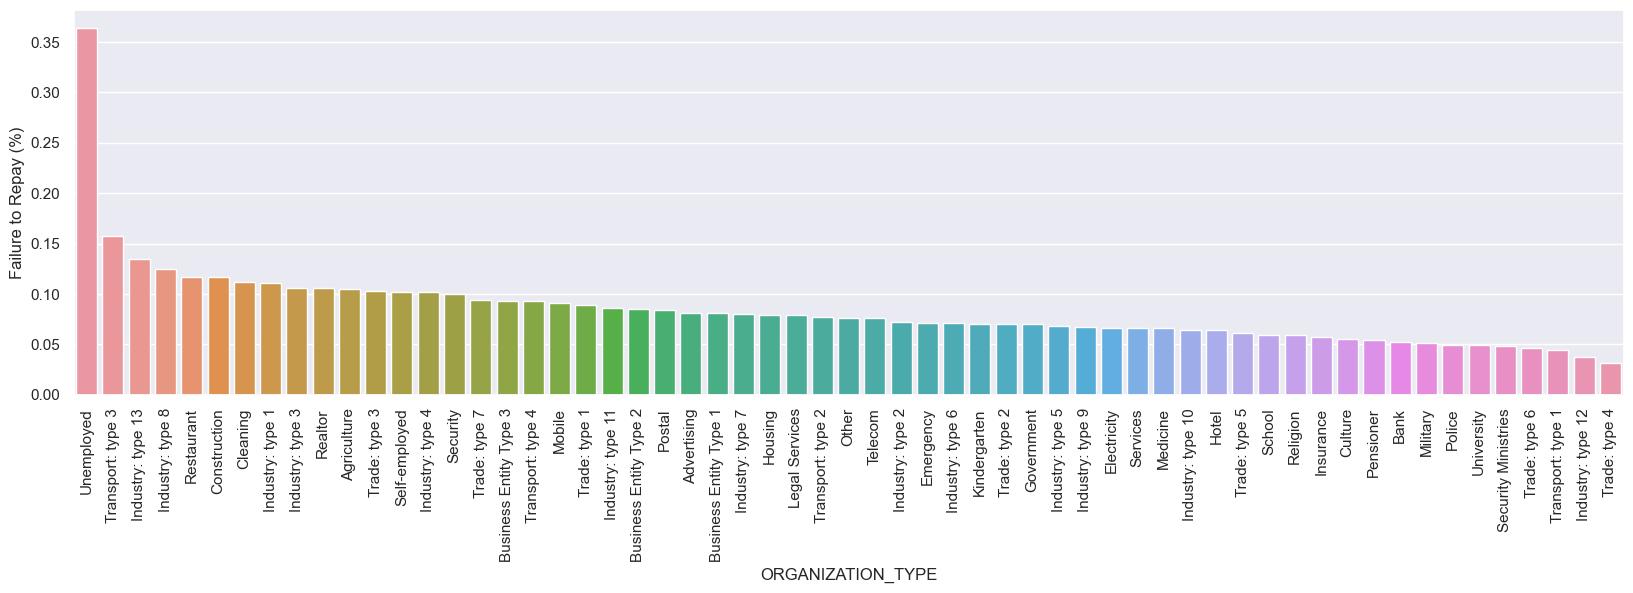

In [137]:
compare_target_categ(train, 'ORGANIZATION_TYPE', figsize=(20, 5), rotate=True, order=True)

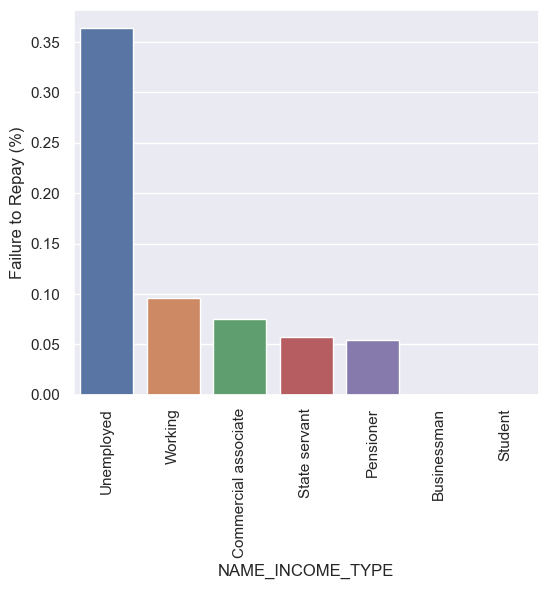

In [138]:
compare_target_categ(train, 'NAME_INCOME_TYPE', figsize=(6, 5), rotate=True, order=True)

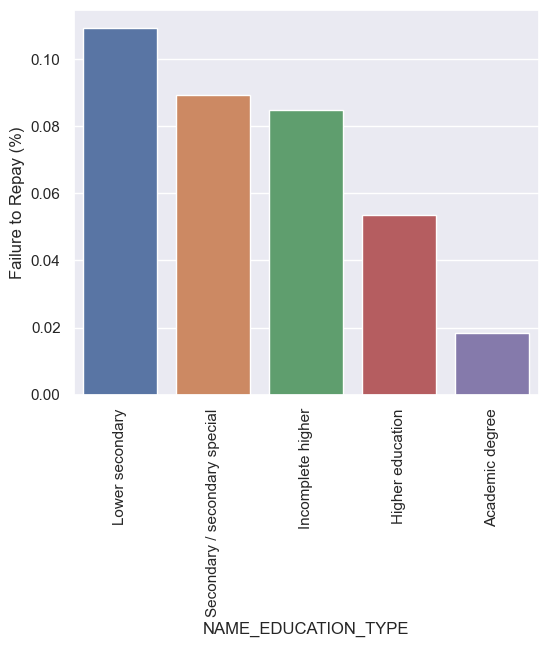

In [139]:
compare_target_categ(train, 'NAME_EDUCATION_TYPE', figsize=(6, 5), rotate=True, order=True)

Plus le niveau d'éducation est élevé plus le taux de défaut de paiement moyen est faible.

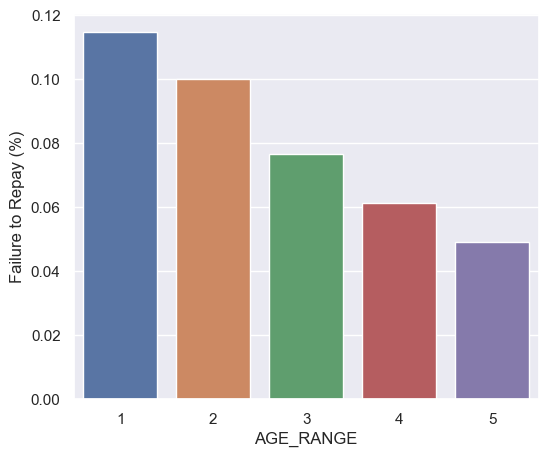

In [140]:
compare_target_categ(train, 'AGE_RANGE', figsize=(6, 5))

Plus les clients sont jeunes plus le taux de défaut de paiement moyen est élevé.

Nous allons maintenant calculer l'IV pour les variables quantitatives.

In [141]:
IV = iv_woe(train[list(set(train.columns) - set(list_var_categ))], 'TARGET', bins=10).sort_values(by='IV', ascending=False)
IV

,Variable,IV
0,EXT_SOURCE_MEAN,0.608282
0,EXT_SOURCE_2*EXT_SOURCE_3,0.489530
0,EXT_SOURCE_3*DAYS_BIRTH,0.341220
0,EXT_SOURCE_2*DAYS_BIRTH,0.335836
0,EXT_SOURCE_3,0.329435
...,...,...
0,OBS_30_CNT_SOCIAL_CIRCLE,0.003239
0,CNT_FAM_MEMBERS,0.003201
0,CNT_CHILDREN,0.001656
0,FLAG_DOCUMENT_8,0.000905


Les variables créées lors du feature engineering à partir des variables "EXT_SOURCE" font parties des variables les plus informatives.
Cela peut s'illustrer en comparant les distributions des clients ayant remboursé ou non.

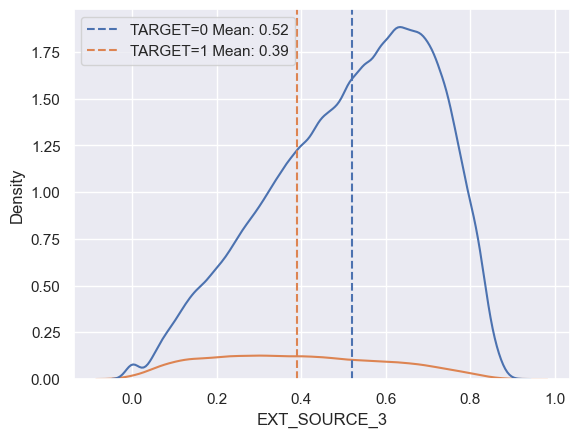

In [142]:
compare_target(train, 'EXT_SOURCE_3')

On observe des distributions très différentes. Les clients n'ayant pas remboursé leur prêt ont en moyenne un score "EXT_SOURCE_3 plus faible que les clients qui ont remboursés.

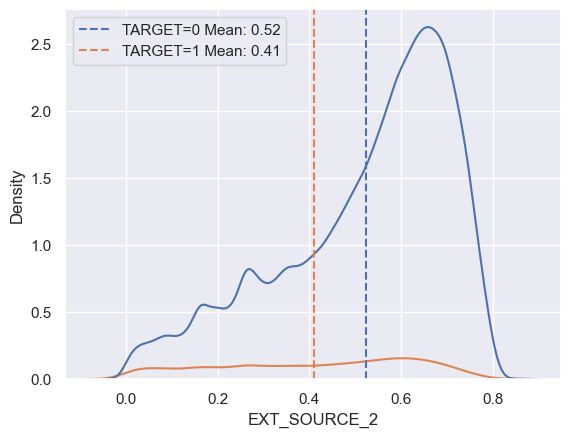

In [143]:
compare_target(train, 'EXT_SOURCE_2')

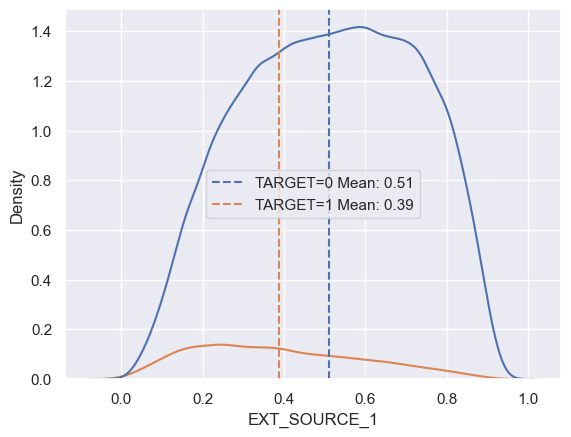

In [144]:
compare_target(train, 'EXT_SOURCE_1')

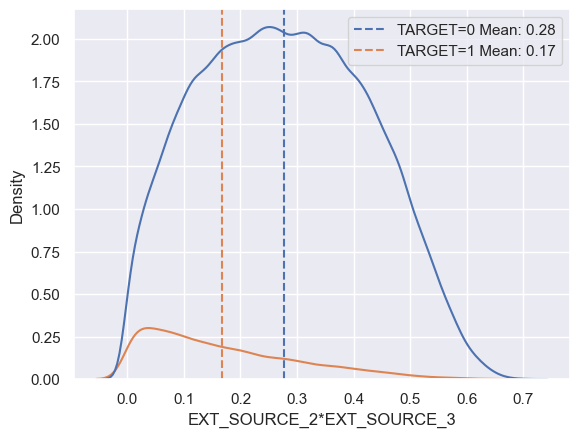

In [145]:
compare_target(train, 'EXT_SOURCE_2*EXT_SOURCE_3')